# Microearthquake (MEQ) and Reservoir Parameter Data Analytics

## Business Problem 

This notebook contains descriptive data analysis and visualization of microearthquake (MEQ) data and reservoir engineering operational parameters from a particular geothermal field. Operational parameters such as injection rate, wellhead pressure, total injection quantity, well location, and geologic and geomechanical characteristics are known to affect the rate of induced earthquakes (He et al., 2020; Hofmann et al., 2018), therefore the collaborative analysis of induced seismicity and operational parameter shall be carried out.

The notebook includes a quality check of the microearthquake catalogue (MEQ) from December 2019 to October 2023, spatial and temporal analysis of the MEQ catalogue data, calculation of the total number of microearthquake events over time, analysis of operational reservoir data, and the joint analysis of microseismicity and reservoir operational parameters.

The goal of this project is to performing MEQ catalogue data quality control, depicting patterns hidden within the seismicity data, as well as understand injection-induced microseismicity in the geothermal system using integrated data analysis of MEQ and reservoir operational parameter. However, it should be noted that after the event ID 636 went straight to ID 2001, as the data came from two different sources.

## Data Understanding

| Attribute | Description |
| --- | --- |
| ID | The data ID of the recorded microearthquake |
| Lat | Latitudinal coordinates of the MEQ event |
| Lon | Longitudinal coordinates of the MEQ event |
| UTM X (m) | Easting coordinates of the MEQ event in UTM coordinate system |
| UTM Y (m) | Northing coordinates of the MEQ event in UTM coordinate system |
| Elev (down is +m) | The depth of a microseismic event is in metres, the depth will be negative if it is above sea level |
| Elev (m) | The height of a microseismic event is in metres, the height is negative if it is below the surface. |
| Year | Year in which a microseismic event was recorded in an ID |
| Month | Month in which a microseismic event was recorded in an ID |
| Day | Day in which a microseismic event was recorded in an ID |
| Hour | Hour in which a microseismic event was recorded in an ID |
| Minute | Minute in which a microseismic event was recorded in an ID |
| Origin (s) | Second in which a microseismic event was recorded in an ID |
| RMS (s) | Value of error of microseismic event |
| Ml Magnitude | Local magnitude value |
| Mw Magnitude | Moment magnitude value |
| Remarks | Description of the type of micro-earthquake; initial or re-located, or re-located by the waveform cross-correlation process |

#### Library Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns
import missingno
import plotly.graph_objects as go

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from scipy.stats import normaltest
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Microearthquake Catalogue Compilation from 2019 - October 2023

In [2]:
df = pd.read_excel('Hypocenter Catalog December 2019 - October 2023.xlsx') 
df

,ID,Lat,Lon,UTM X,UTM Y,Elev (down is +m),Elev (masl),Year,Month,Day,Hour,Minute,Origin (s),RMS (s),MI Magnitude,Mw Magnitude,Remarks
0,1,-1.612807,101.115871,735404.6068,9821613.517,1178.000,-1178.000,2019,12,9,18,40,30.540000,0.025000,NaN,0.585198,Reloc
1,2,-1.609600,101.155410,739806.0245,9821963.623,4507.730,-4507.730,2019,12,18,20,49,23.006000,0.000000,NaN,0.247536,Initial
2,3,-1.543080,101.223900,747437.7160,9829313.520,2095.740,-2095.740,2019,12,19,10,39,15.719000,3.910000,NaN,0.624419,Initial
3,4,-1.627960,101.131940,737191.4514,9819935.609,638.250,-638.250,2019,12,19,15,20,24.800000,0.000000,NaN,0.097204,Initial
4,5,-1.638751,101.150484,739254.2780,9818739.832,758.000,-758.000,2019,12,23,16,58,41.780000,0.010000,NaN,0.121377,WCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,3284,-1.642259,101.142448,738359.3780,9818352.809,776.460,-776.460,2023,10,14,16,31,41.020001,0.002658,NaN,NaN,WCC
1530,3285,-1.642577,101.139429,738023.2800,9818317.951,719.500,-719.500,2023,10,17,8,13,56.790001,0.002386,NaN,NaN,WCC
1531,3286,-1.645168,101.135295,737562.8180,9818031.846,786.150,-786.150,2023,10,17,9,1,32.360001,0.002576,NaN,NaN,WCC
1532,3287,-1.631970,101.121634,736043.8990,9819493.304,212.358,-212.358,2023,10,18,0,33,19.668341,0.009786,NaN,NaN,Initial


A total of **1534 MEQ events** were detected over a period of **±4 years**.

Given that the data has separate `Year`, `Month`, `Day` features, a new feature can be obtained that represents the date, which is useful for analysing temporal domain.

In [3]:
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df

,ID,Lat,Lon,UTM X,UTM Y,Elev (down is +m),Elev (masl),Year,Month,Day,Hour,Minute,Origin (s),RMS (s),MI Magnitude,Mw Magnitude,Remarks,date
0,1,-1.612807,101.115871,735404.6068,9821613.517,1178.000,-1178.000,2019,12,9,18,40,30.540000,0.025000,NaN,0.585198,Reloc,2019-12-09
1,2,-1.609600,101.155410,739806.0245,9821963.623,4507.730,-4507.730,2019,12,18,20,49,23.006000,0.000000,NaN,0.247536,Initial,2019-12-18
2,3,-1.543080,101.223900,747437.7160,9829313.520,2095.740,-2095.740,2019,12,19,10,39,15.719000,3.910000,NaN,0.624419,Initial,2019-12-19
3,4,-1.627960,101.131940,737191.4514,9819935.609,638.250,-638.250,2019,12,19,15,20,24.800000,0.000000,NaN,0.097204,Initial,2019-12-19
4,5,-1.638751,101.150484,739254.2780,9818739.832,758.000,-758.000,2019,12,23,16,58,41.780000,0.010000,NaN,0.121377,WCC,2019-12-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,3284,-1.642259,101.142448,738359.3780,9818352.809,776.460,-776.460,2023,10,14,16,31,41.020001,0.002658,NaN,NaN,WCC,2023-10-14
1530,3285,-1.642577,101.139429,738023.2800,9818317.951,719.500,-719.500,2023,10,17,8,13,56.790001,0.002386,NaN,NaN,WCC,2023-10-17
1531,3286,-1.645168,101.135295,737562.8180,9818031.846,786.150,-786.150,2023,10,17,9,1,32.360001,0.002576,NaN,NaN,WCC,2023-10-17
1532,3287,-1.631970,101.121634,736043.8990,9819493.304,212.358,-212.358,2023,10,18,0,33,19.668341,0.009786,NaN,NaN,Initial,2023-10-18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 1534 non-null   int64         
 1   Lat                1534 non-null   float64       
 2   Lon                1534 non-null   float64       
 3   UTM X              1534 non-null   float64       
 4   UTM Y              1534 non-null   float64       
 5   Elev (down is +m)  1534 non-null   float64       
 6   Elev (masl)        1534 non-null   float64       
 7   Year               1534 non-null   int64         
 8   Month              1534 non-null   int64         
 9   Day                1534 non-null   int64         
 10  Hour               1534 non-null   int64         
 11  Minute             1534 non-null   int64         
 12  Origin (s)         1534 non-null   float64       
 13  RMS (s)            1534 non-null   float64       
 14  MI Magni

### MEQ Catalogue Quality Check

<Axes: >

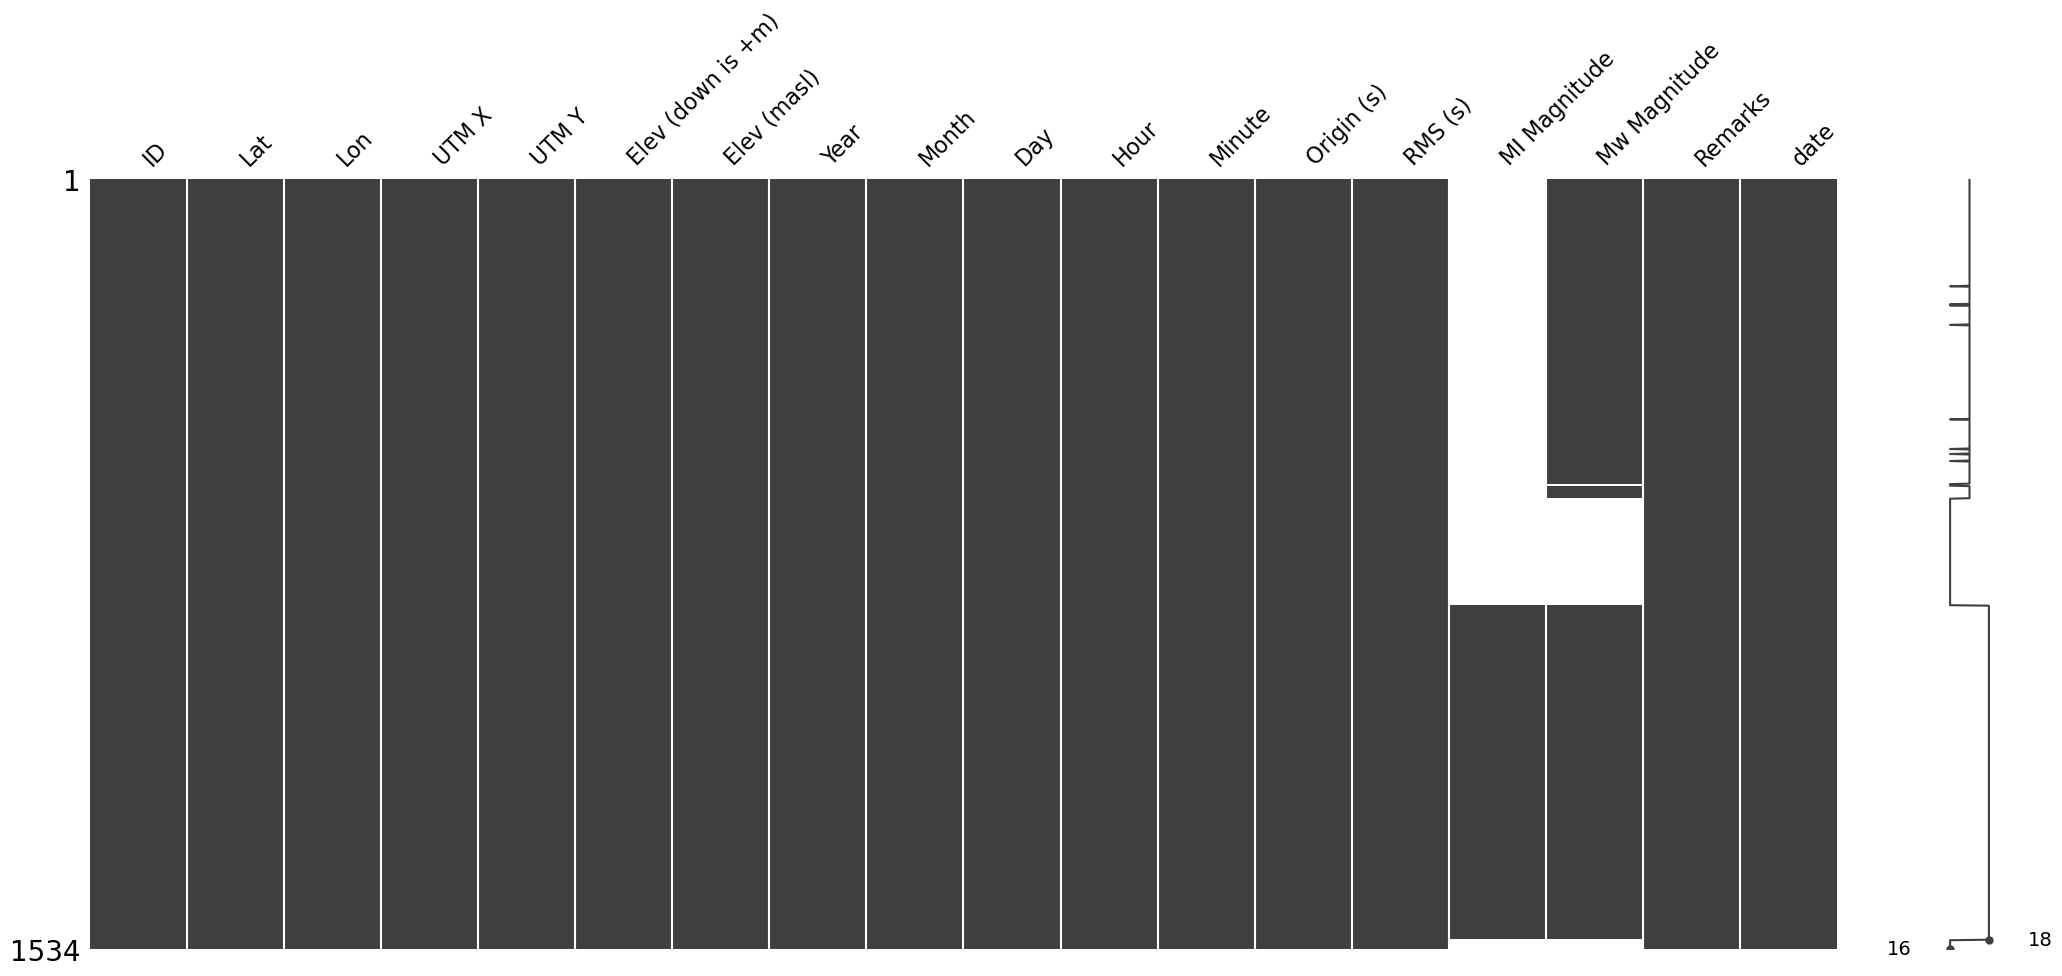

In [5]:
missingno.matrix(df)

In [6]:
df.isna().sum()/df.shape[0]*100

ID                    0.000000
Lat                   0.000000
Lon                   0.000000
UTM X                 0.000000
UTM Y                 0.000000
Elev (down is +m)     0.000000
Elev (masl)           0.000000
Year                  0.000000
Month                 0.000000
Day                   0.000000
Hour                  0.000000
Minute                0.000000
Origin (s)            0.000000
RMS (s)               0.000000
MI Magnitude         56.584094
Mw Magnitude         15.906128
Remarks               0.000000
date                  0.000000
dtype: float64

Local magnitude and moment magnitude from December 2019 – October 2023 comprise **56.5%** and **15.96%** missing values respectively.

In [7]:
missing_values_df = df[['Year', 'Month', 'MI Magnitude']]
missing_values_count = missing_values_df.groupby(['Year', 'Month']).apply(lambda x: x.isnull().any(axis=1))
missing_values_count = missing_values_count[missing_values_count]
missing_values_count = missing_values_count.reset_index()[['Year', 'Month']].drop_duplicates()
missing_values_count.reset_index(drop=True, inplace=True)

print("Year and Month with Missing Value in Local Magnitude Feature:")
missing_values_count

Year and Month with Missing Value in Local Magnitude Feature:


,Year,Month
0,2019,12
1,2020,1
2,2020,2
3,2020,3
4,2020,4
5,2020,5
6,2020,6
7,2020,7
8,2020,8
9,2020,9


In [8]:
missing_values_df = df[['Year', 'Month', 'Mw Magnitude']]
missing_values_count = missing_values_df.groupby(['Year', 'Month']).apply(lambda x: x.isnull().any(axis=1))
missing_values_count = missing_values_count[missing_values_count]
missing_values_count = missing_values_count.reset_index()[['Year', 'Month']].drop_duplicates()
missing_values_count.reset_index(drop=True, inplace=True)

print("Year and Month with Missing Value in Moment Magnitude Feature:")
missing_values_count

Year and Month with Missing Value in Moment Magnitude Feature:


,Year,Month
0,2020,2
1,2020,3
2,2020,4
3,2020,5
4,2020,6
5,2020,7
6,2020,10
7,2020,12
8,2021,1
9,2021,2


There are still missing values for local features and moment magnitudes from 2020 to the beginning of quarter 2022. However, the presence of missing values is mainly found for local magnitude features.

### Handling Missing Value

The K-Nearest Neighbors (KNN) imputation method is highly effective in filling missing values due to its ability to preserve the distributional characteristics of the data features being imputed. By leveraging the values of the nearest neighbors, KNN considers the actual data within the dataset without making assumptions about the data distribution, and it can handle inter-feature relationships. Moreover, by considering multiple nearest neighbors, KNN can capture subtle variations in the data, contributing to accurate imputation. 

However, it is crucial to select the appropriate value for the parameter k, and it should be noted that the performance of KNN may be influenced by the dimensionality of the data and computational time for large datasets.

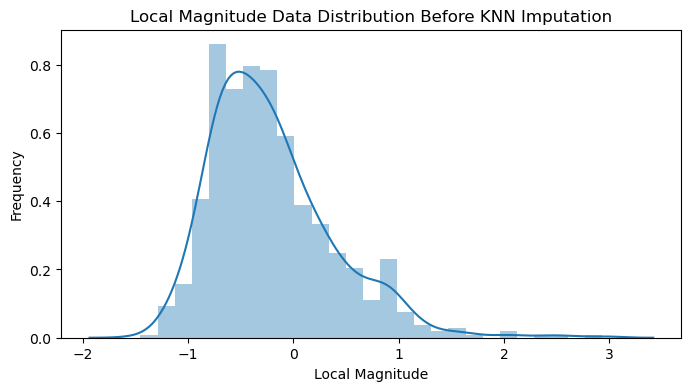

In [9]:
plt.figure(figsize=(8,4))
sns.distplot(df['MI Magnitude'])
plt.xlabel('Local Magnitude', size = 10)
plt.ylabel('Frequency', size = 10)
plt.title('Local Magnitude Data Distribution Before KNN Imputation')

plt.show()

The only parameter that adjusts KNN complexity is the number of neighbours k. The larger k, the smoother the boundary. Or we can think of KNN complexity decreasing as k increases.

In [10]:
# Select Numerical Column
numeric_columns = df.select_dtypes(include=['float64']).columns

# KNN Imputer
imputer = KNNImputer(n_neighbors=4)

# Perform imputation on a DataFrame for numeric columns only
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

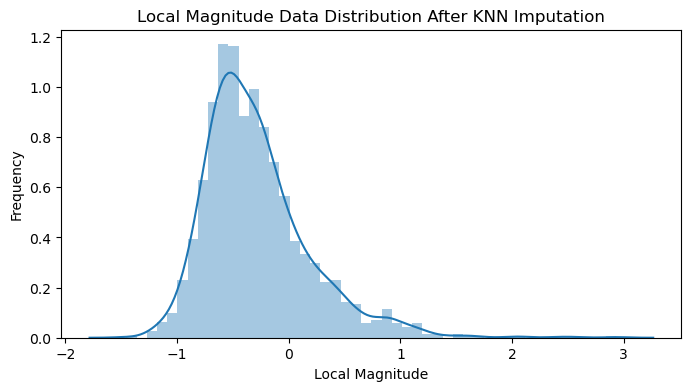

In [11]:
plt.figure(figsize=(8,4))
sns.distplot(df['MI Magnitude'])
plt.xlabel('Local Magnitude', size = 10)
plt.ylabel('Frequency', size = 10)
plt.title('Local Magnitude Data Distribution After KNN Imputation')

plt.show()

After imputing in the missing values using the KNN imputation method, the data distribution of the feature `MI Magnitude` is still resembling to the data distribution before the imputation method was applied, this showing that the imputation technique was effective.

<Axes: >

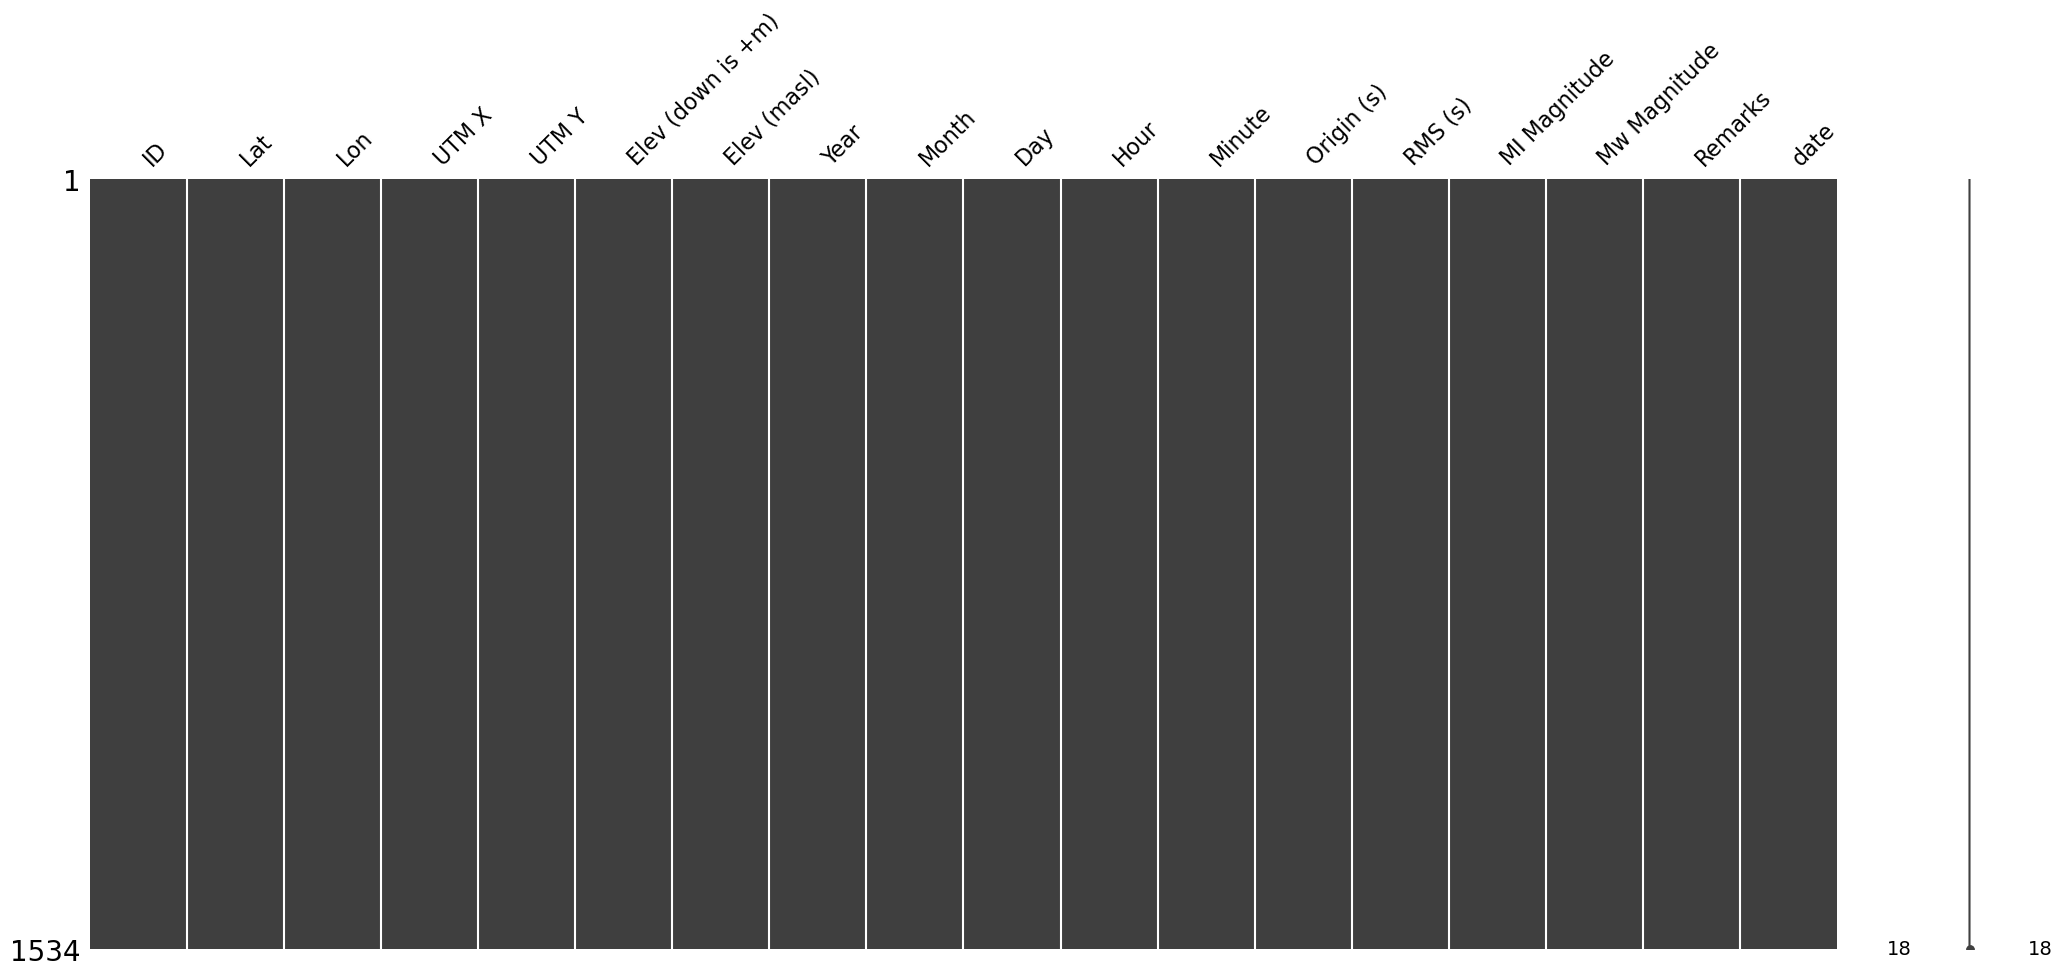

In [12]:
missingno.matrix(df)

In [13]:
# Save to file Excel
#df.to_excel('Hypocenter Catalog December 2020 - October 2023.xlsx', index=False)

### Descriptive Statistics

In [14]:
df.describe()

,ID,Lat,Lon,UTM X,UTM Y,Elev (down is +m),Elev (masl),Year,Month,Day,Hour,Minute,Origin (s),RMS (s),MI Magnitude,Mw Magnitude
count,1534.000000,1534.000000,1534.000000,1534.000000,1.534000e+03,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.00000,1534.000000,1534.000000
mean,1771.303129,-1.637157,101.143727,738502.313660,9.818917e+06,847.922743,-847.922743,2021.433507,5.307040,16.889179,12.287484,28.781617,29.890395,0.02786,-0.284945,0.265516
std,1253.868392,0.017612,0.015569,1733.192242,1.947862e+03,1259.291652,1259.291652,1.385489,3.421888,8.815022,6.809792,17.139424,17.093884,0.27459,0.475183,0.411103
min,1.000000,-1.708499,101.040971,727062.500000,9.811029e+06,-1985.795000,-8127.240000,2019.000000,1.000000,1.000000,0.000000,0.000000,0.121354,-9.00000,-1.454000,-0.810573
25%,384.250000,-1.643059,101.139009,737977.074500,9.818265e+06,431.302500,-952.846250,2020.000000,2.000000,8.000000,7.000000,14.000000,15.825000,0.01400,-0.603000,-0.017000
50%,2421.500000,-1.641035,101.144170,738551.519000,9.818488e+06,737.710000,-737.710000,2022.000000,4.000000,19.000000,13.000000,28.000000,29.635000,0.02600,-0.375500,0.189463
75%,2904.750000,-1.637722,101.148794,739065.592050,9.818854e+06,952.846250,-431.302500,2023.000000,9.000000,24.000000,18.000000,43.000000,44.452500,0.03306,-0.065000,0.483250
max,3288.000000,-1.502350,101.319200,758047.213400,9.833825e+06,8127.240000,1985.795000,2023.000000,12.000000,31.000000,23.000000,59.000000,59.919998,4.11000,2.934000,2.483629


Extracted knowledge from the catalog using descriptive statistics:
   - The average depth of the recorded microseismic event was 847.92 m
   - Deepest MEQ event recorded at more than 8000m below the surface.
   - At an altitude of more than 1900m, there is a microseismic event was recorded at the surface.
   - There are outliers in RMS (s) with a minimum value of -9 and a maximum value of 4. Outliers will be further investigated.
   - The highest local magnitude and moment magnitude is 2.934000 and 2.483629 respectively; meaning that all the events in the catalog are considered as microearthquake (MEQ event is considered if magnitude < 3)

In [15]:
categoric_data = df.select_dtypes(include="object")

column = categoric_data.columns
unique = [categoric_data[i].unique() for i in column]
n_unique = [len(categoric_data[i].unique()) for i in column]

pd.DataFrame({
    'column': column,
    'n_unique': n_unique,
    'unique': unique
})

,column,n_unique,unique
0,Remarks,3,"[Reloc, Initial, WCC]"


In [16]:
#data_magnitude = df[['MI Magnitude','Mw Magnitude']]
#data_magnitude.boxplot();
#plt.ylabel('Value', size = 10)
#plt.title('Magnitude Boxplot', size = 15)
#plt.grid(True)
#plt.show()

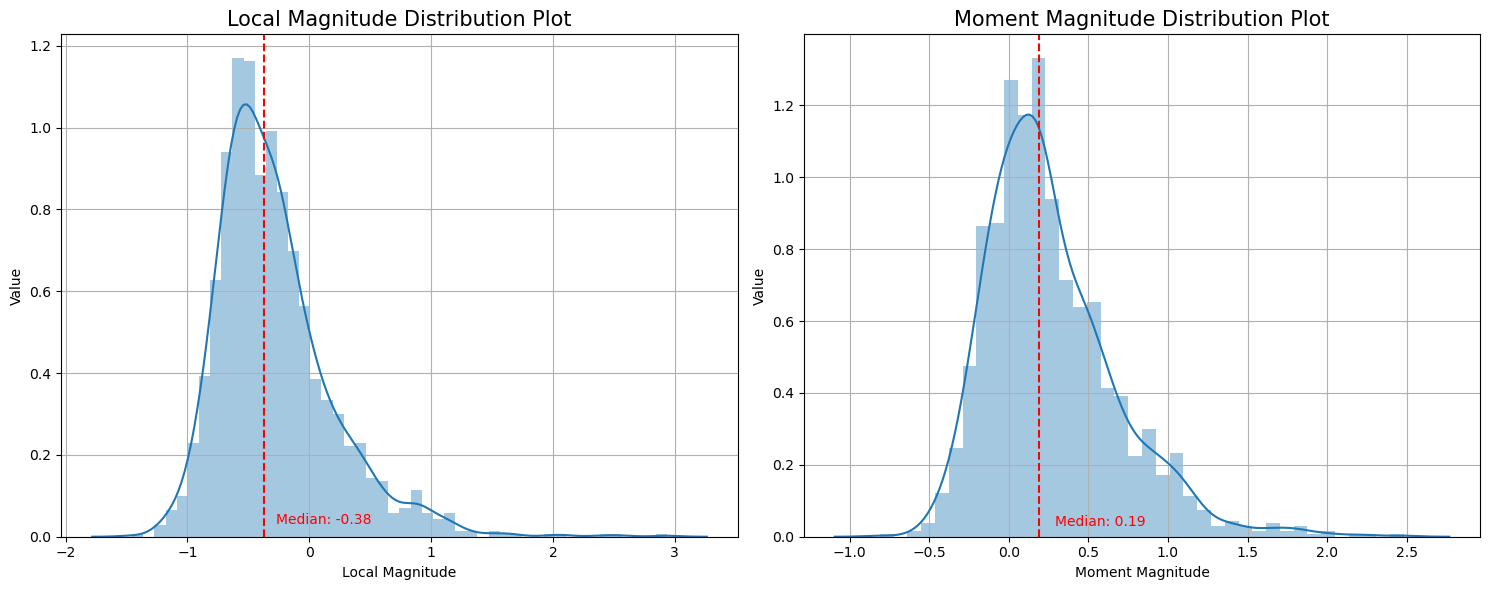

In [17]:
df_ml_magnitude = df[['MI Magnitude']] 
df_mw_magnitude = df[['Mw Magnitude']] 

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.distplot(df_ml_magnitude, ax=axs[0])
axs[0].set_xlabel('Local Magnitude', size=10)
axs[0].set_ylabel('Value', size=10)
axs[0].set_title('Local Magnitude Distribution Plot', size=15)
axs[0].grid(True)

median_ml = df_ml_magnitude.median().values[0]
axs[0].axvline(median_ml, color='red', linestyle='--')
axs[0].text(median_ml + 0.1, 0.03, f'Median: {median_ml:.2f}', color='red', fontsize=10)


sns.distplot(df_mw_magnitude, ax=axs[1])
axs[1].set_xlabel('Moment Magnitude', size=10)
axs[1].set_ylabel('Value', size=10)
axs[1].set_title('Moment Magnitude Distribution Plot', size=15)
axs[1].grid(True)

median_mw = df_mw_magnitude.median().values[0]
axs[1].axvline(median_mw, color='red', linestyle='--')
axs[1].text(median_mw + 0.1, 0.03, f'Median: {median_mw:.2f}', color='red', fontsize=10)

plt.tight_layout()

plt.show()

- Both local and moment magnitude are characterized with right-skewed distribution, therefore the median used as their central tendency.
- Local and moment magnitude from microseismicity catalogue are -0.38 and 0.19 correspondingly.

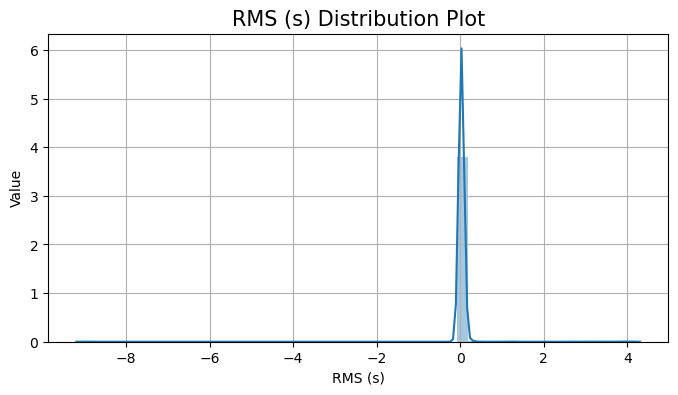

In [18]:
df_rms = df[['RMS (s)']] 
plt.figure(figsize=(8,4))
sns.distplot(df_rms)
plt.xlabel('RMS (s)', size = 10)
plt.ylabel('Value', size = 10)
plt.title('RMS (s) Distribution Plot', size = 15)
plt.grid(True)
plt.show()

A few data showed outside in the range of 0 – 1 RMS error; these data will be filtered

In [19]:
# Filter data with RMS (s) values outside the specified range
outliers_RMS = df[(df['RMS (s)'] < -1) | (df['RMS (s)'] > 1)]
outliers_RMS[['ID', 'Year', 'Month', 'RMS (s)']]

,ID,Year,Month,RMS (s)
2,3,2019,12,3.91
560,561,2020,7,1.23
566,567,2020,8,4.11
628,629,2020,11,-9.00


There are 4 outliers because their RMS(s) are outside the range 0 - 1

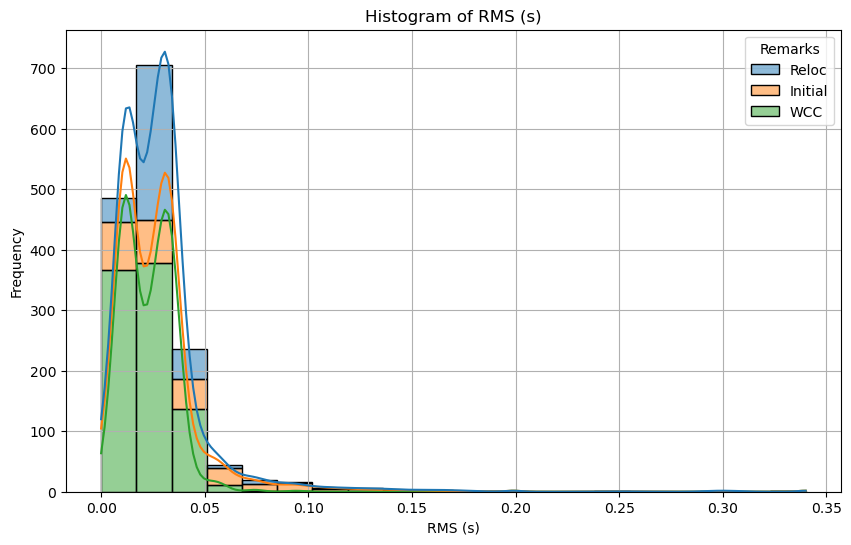

In [20]:
# Filter data with RMS (s) values outside the specified range
df = df[(df['RMS (s)'] > -1) & (df['RMS (s)'] < 1)]

# Plot histogram with hue based on Remarks
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='RMS (s)', bins=20, kde=True, hue='Remarks', multiple="stack")
plt.xlabel('RMS (s)')
plt.ylabel('Frequency')
plt.title('Histogram of RMS (s)')
plt.grid(True)
plt.show()


Filtered dataset showed MEQ events has dominant RMS (s) in the range of **0.00 – 0.05**

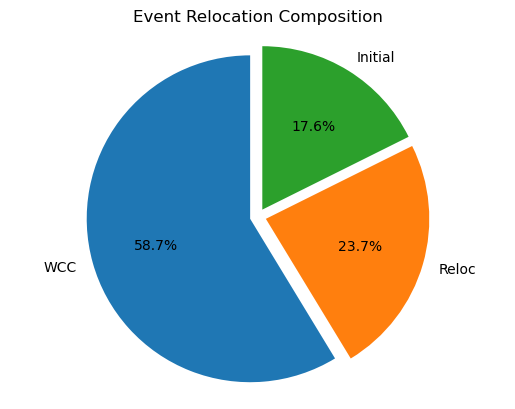

In [21]:
# Count the values in the 'y' column
value_counts = df['Remarks'].value_counts()

# Create a pie chart
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, explode = [0.05,0.05, 0.05])
plt.title('Event Relocation Composition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

The majority of the data, **58.7%** of all MEQ events, **have been processed** through the **waveform cross-correlation (WCC)** technique.

Repetition of dates in the dataset is used as a count to calculate the total number of microseismic events that occurred on that date, then the total daily count of microseismic events is stored in an Excel format file (.xlsx) which can be used for data interpretation needs by combining it with other subsurface data such as injection rate.

In [22]:
value_counts_result = df['date'].value_counts().reset_index()
value_counts_result.columns = ['date', 'total_meq_events']

# create a range of date
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
full_date_df = pd.DataFrame({'date': full_date_range})

# combined with the value_counts() result and filled missing value with 0 
result_df = pd.merge(full_date_df, value_counts_result, on='date', how='left').fillna(0)

# ordered by date
result_df = result_df.sort_values(by='date')

# Save to file Excel
#result_df.to_excel('Total_MEQ_Events.xlsx', index=False)

### Summary MEQ Catalogue Data Quality

- The MEQ catalogue dataset from December 2019 to October 2023 still has predominantly missing values in the local and moment magnitude features, but for the purpose of data analysis, the missing values were successfully filled using the KNN imputer.
- All events recorded in the dataset are classified as microseismic, as there are no magnitudes greater than 3
- MEQ events were predominantly processed up to the WCC data processing stage.
- Local magnitude and moment magnitude have right-skewed distribution, therefore their median are -0.38 and 0.19 respectively.
- MEQ events majorly have an RMS error range in the range of 0 - 0.05, this indicates that this MEQ catalog is reliable.

## Microseismicity Data Analytics

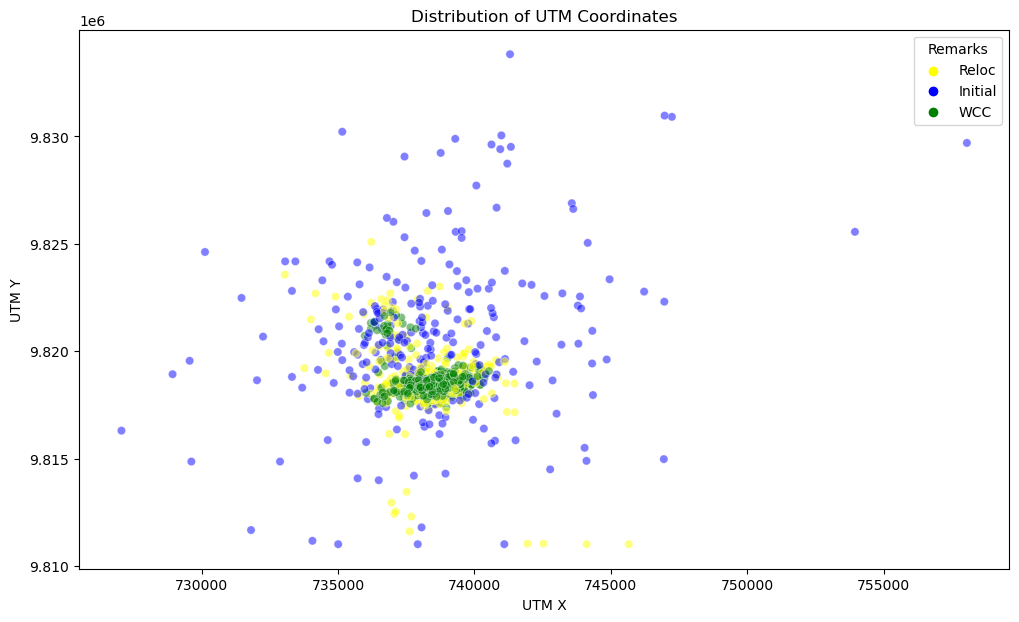

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(x='UTM X', y='UTM Y', hue='Remarks', alpha=0.5,
                palette={"Initial": "blue", "Reloc": "yellow", "WCC": "green"},
                data=df, ax=ax)

ax.set_xlabel('UTM X')
ax.set_ylabel('UTM Y')
ax.set_title('Distribution of UTM Coordinates')

ax.legend(title='Remarks')

plt.show()

- From the geospatial plot, it can be seen that the WCC event relocation has 2 clusters 
- WCC event relocation with ENE-WSW oriented clusters is more centered in the zone between 735000 - 740000 UTM X and 9.8175 - 9.8200 UTM Y

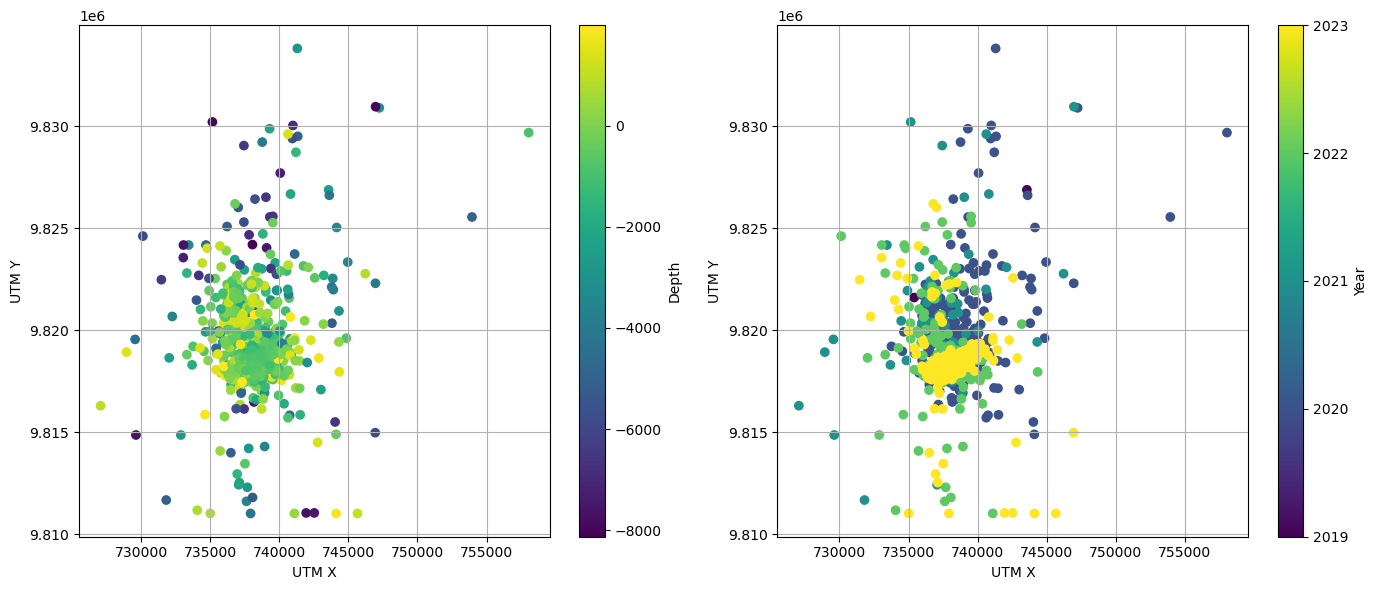

In [24]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
depth_start = min(df['Elev (masl)'])
depth_end = max(df['Elev (masl)'])
plt.scatter(df['UTM X'], df['UTM Y'], c=df['Elev (masl)'], cmap='viridis')
plt.colorbar(label='Depth')
plt.xlabel('UTM X')
plt.ylabel('UTM Y')

plt.grid(True)


plt.subplot(1, 2, 2)
year_start = min(df['Year'])
year_end = max(df['Year'])
plt.scatter(df['UTM X'], df['UTM Y'], c=df['Year'], cmap='viridis')
plt.colorbar(ticks=range(year_start, year_end + 1), label='Year')
plt.xlabel('UTM X')
plt.ylabel('UTM Y')

plt.grid(True)


plt.tight_layout()

- In the southern and northwestern regions there are MEQ events that occurred in 2023 but at depths > 3000 m
- MEQ events dominantly occurred at the shallower depth 0 – 2000 m

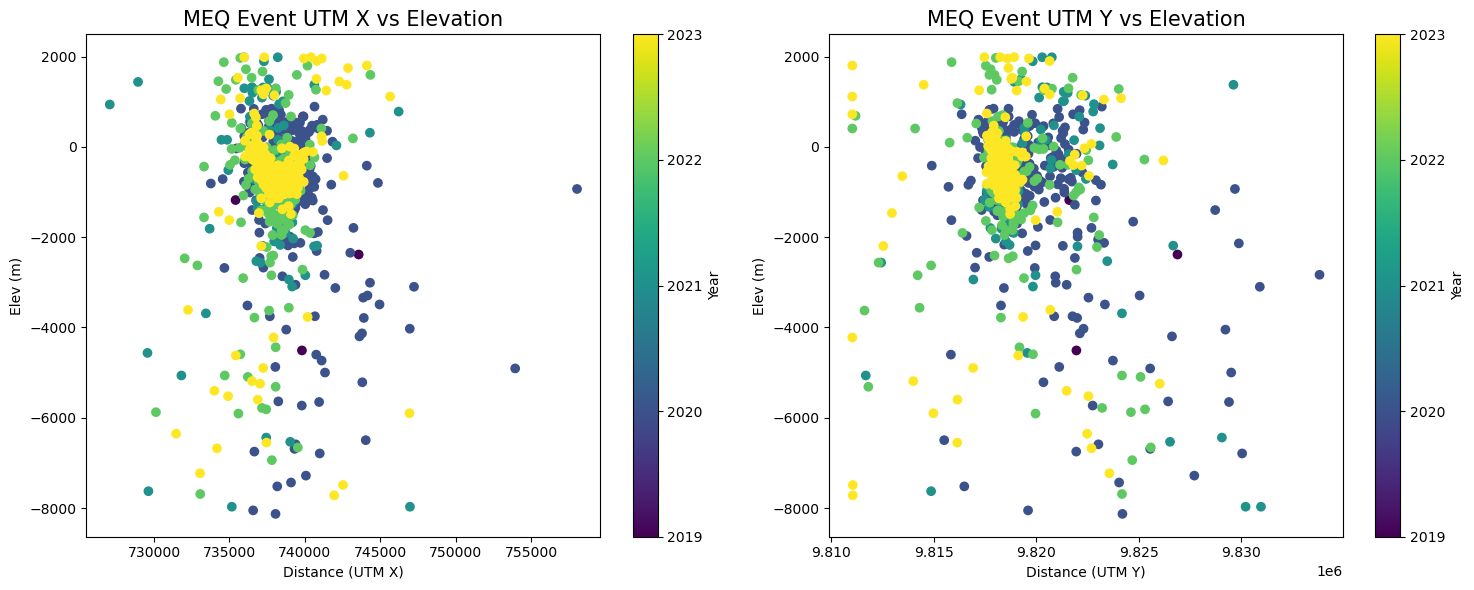

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = axs[0].scatter(df['UTM X'], df['Elev (masl)'], c=df['Year'], cmap='viridis')
axs[0].set_title('MEQ Event UTM X vs Elevation', size=15)
plt.colorbar(scatter1, ax=axs[0], ticks=range(year_start, year_end + 1), label='Year')
axs[0].set_xlabel('Distance (UTM X)')
axs[0].set_ylabel('Elev (m)')

scatter2 = axs[1].scatter(df['UTM Y'], df['Elev (masl)'], c=df['Year'], cmap='viridis')
axs[1].set_title('MEQ Event UTM Y vs Elevation', size=15)
plt.colorbar(scatter2, ax=axs[1], ticks=range(year_start, year_end + 1), label='Year')
axs[1].set_xlabel('Distance (UTM Y)')
axs[1].set_ylabel('Elev (m)')

plt.tight_layout()
plt.show()


- MEQ events that occurred at the shallower depth majorly triggered in 2023

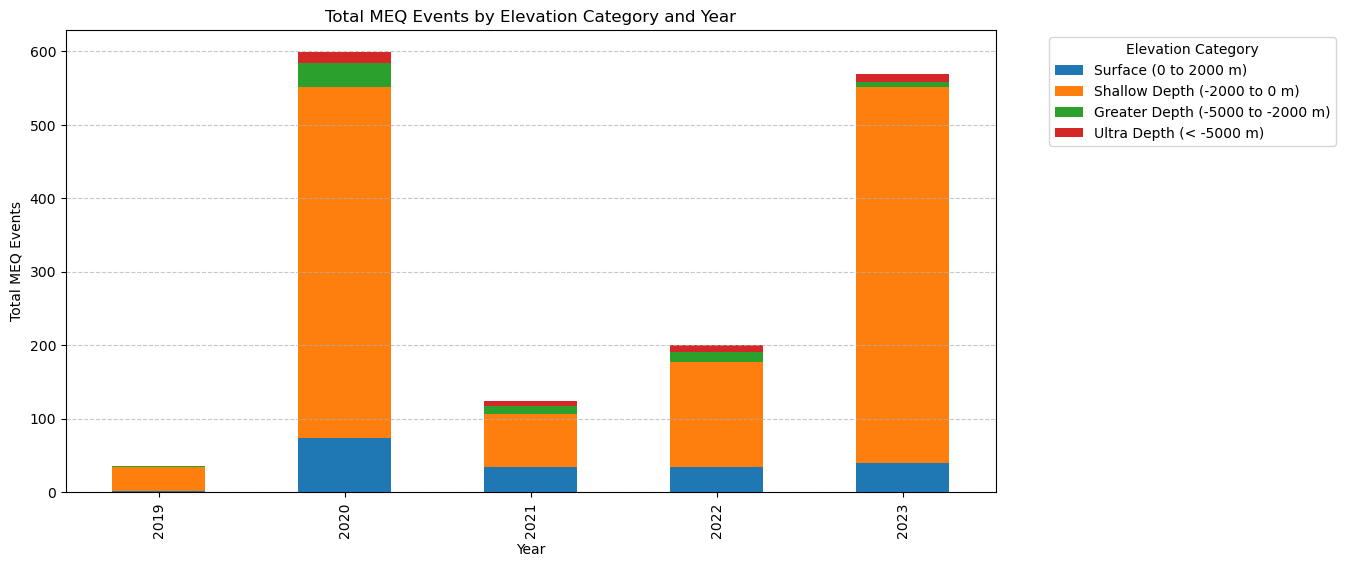

In [26]:
# Categorize based on Elev (masl)
def categorize_elevation(elevation):
    if elevation >= 0 and elevation <= 2000:
        return 'Surface (0 to 2000 m)'
    elif elevation >= -2000 and elevation < 0:
        return 'Shallow Depth (-2000 to 0 m)'
    elif elevation >= -5000 and elevation < -2000:
        return 'Greater Depth (-5000 to -2000 m)'
    elif elevation < -5000:
        return 'Ultra Depth (< -5000 m)'

# Applied categorize_elevation function to the dataset df
df['Elevation Category'] = df['Elev (masl)'].apply(categorize_elevation)

# Determined the category order
category_order = ['Surface (0 to 2000 m)', 'Shallow Depth (-2000 to 0 m)', 'Greater Depth (-5000 to -2000 m)', 'Ultra Depth (< -5000 m)']

# Group data based on year and elevation category
grouped_df = df.groupby(['Year', 'Elevation Category']).size().unstack(fill_value=0)

# Create stacked bar plot visualization
grouped_df = grouped_df[category_order]
grouped_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Total MEQ Events')
plt.title('Total MEQ Events by Elevation Category and Year')
plt.legend(title='Elevation Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Note: 2019 recording data is only available for the month of December

Extracted knowledge: 

- Although in 2020 there were a lot of triggering microearthquakes, there was an extremely drastic decrease in 2021.
- From 2021 to 2023 there was an increment where a significant surge in MEQ events occurred from 2022 to 2023.
- MEQ events that dominantly occur from year-to-year are at shallow depth.
- 2020 also shows the most recorded MEQ events from the surface and greater depth categories.

The MEQ hypocenter locations appear to be highly dependent on:
- Operational parameters (injection rates, wellhead pressure, etc)
- Geological features (structures, lithology, and location of feedzones)
- Geomechanical characteristics (principle horizontal stress Shmin and Shmax, etc)
- Formation saturation

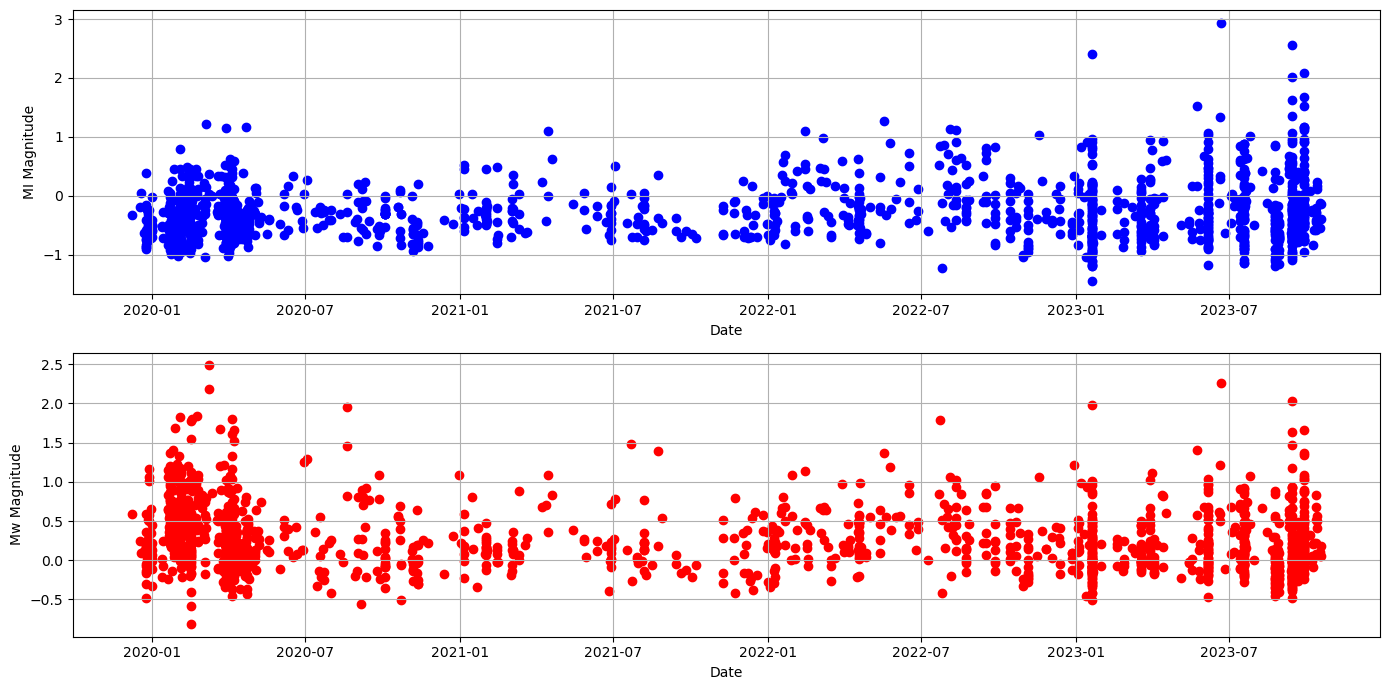

In [27]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.scatter(df['date'], df['MI Magnitude'], color='blue')
plt.xlabel('Date')
plt.ylabel('MI Magnitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.scatter(df['date'], df['Mw Magnitude'], color='red')
plt.xlabel('Date')
plt.ylabel('Mw Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()


In the first half of 2020, microseismic events are remarkably high, and at the beginning of the second half of 2023, the intensity of microseismic events is again relatively high. However, the intensity of microseismic events is relatively low from the second half of 2020 until the end of 2021. It then gradually increases throughout 2022 until, and significantly increases starting second half of 2023.

In [28]:
df.drop(['date'], axis=1, inplace=True)

In [29]:
# Save to file Excel
#df.to_excel('Data MEQ Hypocenter Catalog Supreme Dec 2019 - Oct 2023.xlsx', index=False)

In [30]:
df2 = pd.read_excel('Total_MEQ_Events.xlsx') 
df2

,date,total_meq_events
0,2019-12-09,1
1,2019-12-10,0
2,2019-12-11,0
3,2019-12-12,0
4,2019-12-13,0
...,...,...
1405,2023-10-14,3
1406,2023-10-15,0
1407,2023-10-16,0
1408,2023-10-17,2


In [31]:
df2['cum_sum_meq_event'] = df2['total_meq_events'].cumsum()
df2

,date,total_meq_events,cum_sum_meq_event
0,2019-12-09,1,1
1,2019-12-10,0,1
2,2019-12-11,0,1
3,2019-12-12,0,1
4,2019-12-13,0,1
...,...,...,...
1405,2023-10-14,3,1526
1406,2023-10-15,0,1526
1407,2023-10-16,0,1526
1408,2023-10-17,2,1528


In [32]:
df2.describe()

,total_meq_events,cum_sum_meq_event
count,1410.000000,1410.000000
mean,1.085106,776.346099
std,4.842427,291.915350
min,0.000000,1.000000
25%,0.000000,632.000000
50%,0.000000,739.000000
75%,1.000000,930.000000
max,89.000000,1530.000000


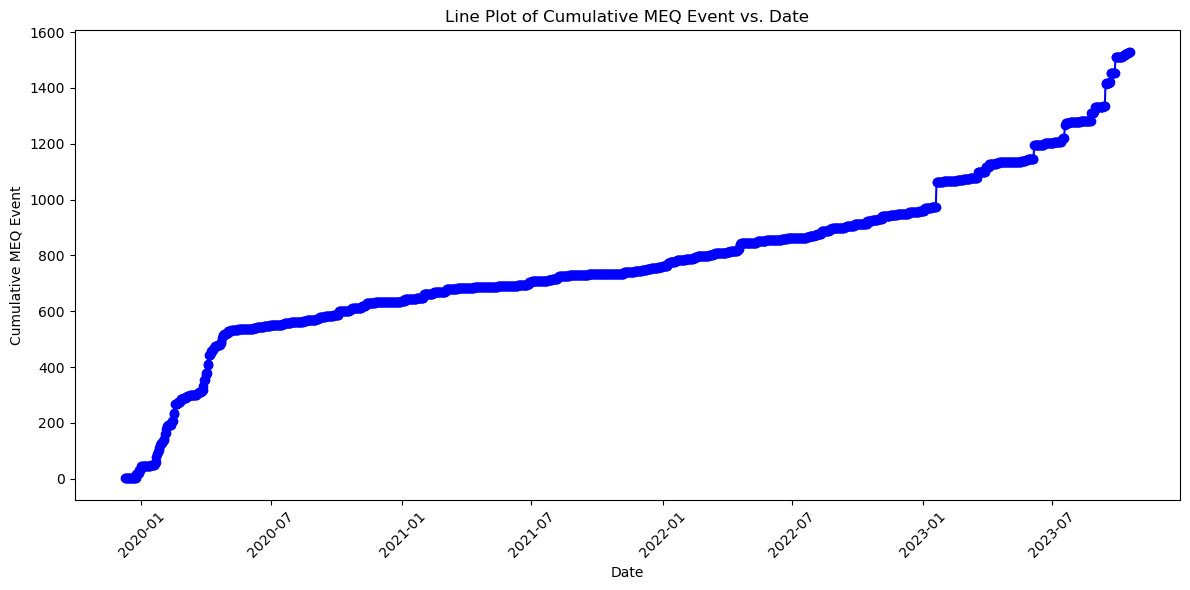

In [34]:
# Plot line plot
plt.figure(figsize=(12, 6))
plt.plot(df2['date'], df2['cum_sum_meq_event'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative MEQ Event')
plt.title('Line Plot of Cumulative MEQ Event vs. Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- There is a significant increase in the cumulative sum of MEQ events in a short period of time in the first half of 2020

In [35]:
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day

In [36]:
df2.describe()

,total_meq_events,cum_sum_meq_event,year,month,day
count,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000
mean,1.085106,776.346099,2021.379433,6.364539,15.712766
std,4.842427,291.915350,1.125233,3.405693,8.776973
min,0.000000,1.000000,2019.000000,1.000000,1.000000
25%,0.000000,632.000000,2020.000000,3.000000,8.000000
50%,0.000000,739.000000,2021.000000,6.000000,16.000000
75%,1.000000,930.000000,2022.000000,9.000000,23.000000
max,89.000000,1530.000000,2023.000000,12.000000,31.000000


- The cumulative number of micro-earthquake events from December 2019 to October 2023 is 1530.

In [37]:
# Filter data hanya pada tahun 2020 - 2023
df_filtered = df2[(df2['year'] >= 2020) & (df2['year'] <= 2023)]

# Menghitung rata-rata event mikroearthquake per tahun
average_meq_events = df_filtered.groupby('year')['total_meq_events'].mean().reset_index()

# Menampilkan rata-rata event mikroearthquake per tahun dalam bentuk dataframe
average_meq_events_df = pd.DataFrame(average_meq_events)
average_meq_events_df.columns = ['Year', 'Average Total MEQ Events / Day']
average_meq_events_df


,Year,Average Total MEQ Events / Day
0,2020,1.636612
1,2021,0.339726
2,2022,0.550685
3,2023,1.958763


- The highest average daily occurrence of induced seismicity happened in 2023.

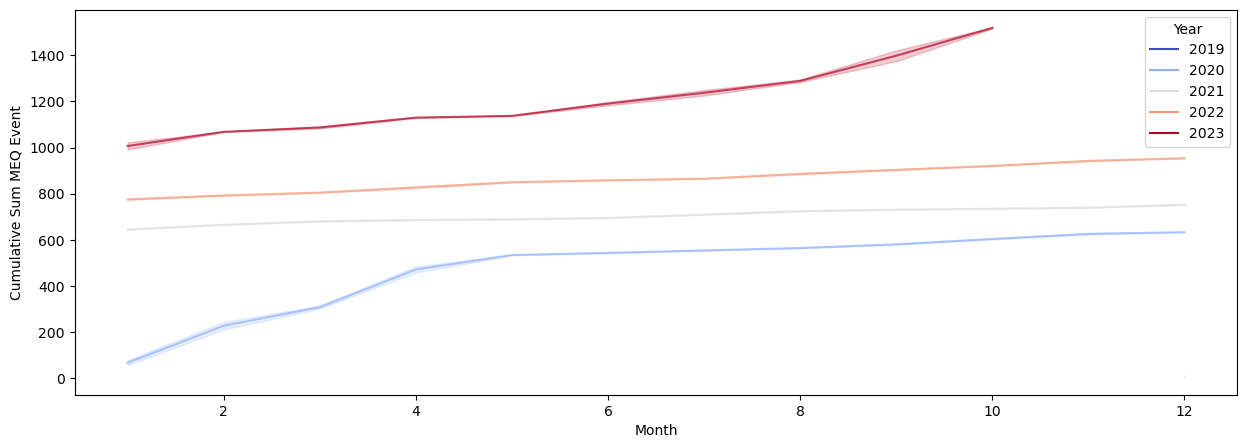

In [38]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='month', y='cum_sum_meq_event', hue='year', data=df2, palette='coolwarm', alpha=0.7)
#sns.lineplot(x='month', y='total_meq_events', hue='year', data=df2)
plt.xlabel('Month')
plt.ylabel('Cumulative Sum MEQ Event')
plt.legend(title='Year', loc='upper right')
plt.show()

- The remarkable increasing activity of induced seismicity occurred in the first five months 2020 and during 2023.

### Summary Microseismicity Data Analysis

- This dataset is comprised of 58.7% of events that have been processed up to the WCC stage, and shows 2 clusters, one of which clearly shows an ENE-WSW orientation.
- **From late 2019 to the fourth quarter of 2023**, the main **majority of MEQ events** occurred at **shallow depths (-2000 - 0 m)**.
- **Exceptional increases** in **seismicity** activity occur in the **first five months of 2020** and **throughout 2023**.

# Reservoir Data 

## Data Understanding

- `Time_Record_ML_Injection_Well`: Date of injection activity 
- `Well Status`: Well status on the date, whether injection is in progress or shut-in.
- `Injection Rate`: fluid injection rate in units (l/s)
- `WHP`: wellhead pressure in units (barg)
- `Injection Temperature`: unit of fluid injection temperature (degrees C)
- `FCV`: flow control valves in %.
- `Total_MEQ_Event`: number of micro-earthquake events on a given day

Set Up of the Injection Well at the Geothermal Field
- ML B1 : Condensate
- ML C1 : Water (Passive)
- ML D1 : Brine
- ML D2 : Brine
- ML E1 : Brine
- ML E2 : Brine

## Injection Rate Data

In [39]:
data = pd.read_excel('Injection Well Jan 2021 - May 2023.xlsx') 
data

,Time_Record_ML_Injection_Well,Well Status ML B1,Injection Rate ML B1 (l/s),Well Status ML C1,Injection Rate ML C1 (l/s),Well Status ML D1,Injection Rate ML D1 (l/s),Well Status ML D2,Injection Rate ML D2 (l/s),Well Status ML E1,Injection Rate ML E1 (l/s),Well Status ML E2,Injection Rate ML E2 (l/s)
0,2021-01-01,Injecting,39.33,Shut-in,NaN,Shut-in,NaN,Injecting,95.4,Injecting,91.0,Injecting,40.0
1,2021-01-02,Injecting,39.33,Shut-in,NaN,Shut-in,NaN,Injecting,96.0,Injecting,91.0,Injecting,40.0
2,2021-01-03,Injecting,39.87,Shut-in,NaN,Shut-in,NaN,Injecting,95.4,Injecting,94.0,Injecting,40.0
3,2021-01-04,Injecting,37.57,Shut-in,NaN,Shut-in,NaN,Injecting,93.4,Injecting,94.0,Injecting,40.0
4,2021-01-05,Injecting,41.78,Shut-in,NaN,Shut-in,NaN,Injecting,75.1,Injecting,93.0,Injecting,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2023-05-23,Injecting,38.24,Injecting,1.6,Shut-In,NaN,Injecting,177.8,Injecting,113.0,Shut-In,NaN
767,2023-05-24,Injecting,38.26,Injecting,1.1,Shut-In,NaN,Injecting,125.3,Injecting,112.0,Shut-In,NaN
768,2023-05-25,Injecting,34.77,Injecting,1.2,Shut-In,NaN,Injecting,177.0,Injecting,113.0,Shut-In,NaN
769,2023-05-26,Injecting,35.48,Injecting,1.4,Shut-In,NaN,Injecting,177.9,Injecting,112.0,Shut-In,NaN


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Time_Record_ML_Injection_Well  771 non-null    datetime64[ns]
 1   Well Status ML B1              771 non-null    object        
 2   Injection Rate ML B1 (l/s)     734 non-null    float64       
 3   Well Status ML C1              770 non-null    object        
 4   Injection Rate ML C1 (l/s)     616 non-null    float64       
 5   Well Status ML D1              771 non-null    object        
 6   Injection Rate ML D1 (l/s)     303 non-null    float64       
 7   Well Status ML D2              770 non-null    object        
 8   Injection Rate ML D2 (l/s)     754 non-null    float64       
 9   Well Status ML E1              771 non-null    object        
 10  Injection Rate ML E1 (l/s)     748 non-null    float64       
 11  Well Status ML E2  

* It can be seen that the reservoir injection rate dataset from 01-21-2021 to 5-29-2023 has 13 columns and 771 rows.
* The injection rate dataset has one column of type datetime, 6 features of type object and 6 features of type numeric.

In [41]:
data.describe()

,Injection Rate ML B1 (l/s),Injection Rate ML C1 (l/s),Injection Rate ML D1 (l/s),Injection Rate ML D2 (l/s),Injection Rate ML E1 (l/s),Injection Rate ML E2 (l/s)
count,734.000000,616.000000,303.000000,754.000000,748.000000,207.000000
mean,37.429837,1.843019,41.730033,146.362202,100.187460,27.992705
std,4.081424,0.532657,15.531395,35.248768,23.107926,13.045180
min,2.500000,0.000000,6.400000,18.700000,22.000000,2.700000
25%,35.892500,1.600000,35.700000,116.940000,70.000000,17.000000
50%,37.770000,1.800000,41.600000,148.650000,113.000000,30.000000
75%,39.230000,2.100000,50.350000,177.775000,117.000000,35.000000
max,60.700000,9.300000,96.200000,250.000000,136.000000,72.300000


* From 21.01.2021 to 29.05.2023, the ML D2 injection well had the highest average fluid injection of 146.36 (l/s) and the highest injection rate value of 250 (l/s).
* The passively used ML C1 well only contributed average 1.84 (l/s) for almost 2.5 years

We need to change the name of the `Time_Record_ML_Injection_Well` feature to `date` in order to merge reservoir data and total MEQ event data tied to the `date` feature

In [42]:
data.rename(columns={'Time_Record_ML_Injection_Well': 'date'}, inplace=True)

In [43]:
categoric_data = data.select_dtypes(include="object")

column = categoric_data.columns
unique = [categoric_data[i].unique() for i in column]
n_unique = [len(categoric_data[i].unique()) for i in column]

pd.DataFrame({
    'column': column,
    'n_unique': n_unique,
    'unique': unique
})

,column,n_unique,unique
0,Well Status ML B1,3,"[Injecting, Shut-in, Shut-In]"
1,Well Status ML C1,4,"[Shut-in, Injecting, nan, Shut-In]"
2,Well Status ML D1,3,"[Shut-in, Injecting, Shut-In]"
3,Well Status ML D2,3,"[Injecting, nan, Shut-in]"
4,Well Status ML E1,2,"[Injecting, Shut-in]"
5,Well Status ML E2,5,"[Injecting, Shut-in, nan, shut-in, Shut-In]"


There should only be 2 unique values in each well status column, namely 'injection' and 'shut-in', but in some features there are more than two unique values. From the unique value table information above, it can be seen that there are inconsistencies in writing, so it will be corrected in the future, there are only two unique values, namely 'Injecting' and 'Shut-in'.

In [44]:
data["Well Status ML B1"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)
data["Well Status ML C1"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)
data["Well Status ML D1"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)
data["Well Status ML D2"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)
data["Well Status ML E2"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)

In [45]:
data.describe(include=['O'])

,Well Status ML B1,Well Status ML C1,Well Status ML D1,Well Status ML D2,Well Status ML E1,Well Status ML E2
count,771,770,771,770,771,770
unique,2,2,2,2,2,2
top,Injecting,Injecting,Shut-in,Injecting,Injecting,Shut-in
freq,744,638,442,759,753,558


### Injection Rate Data Cleaning

<Axes: >

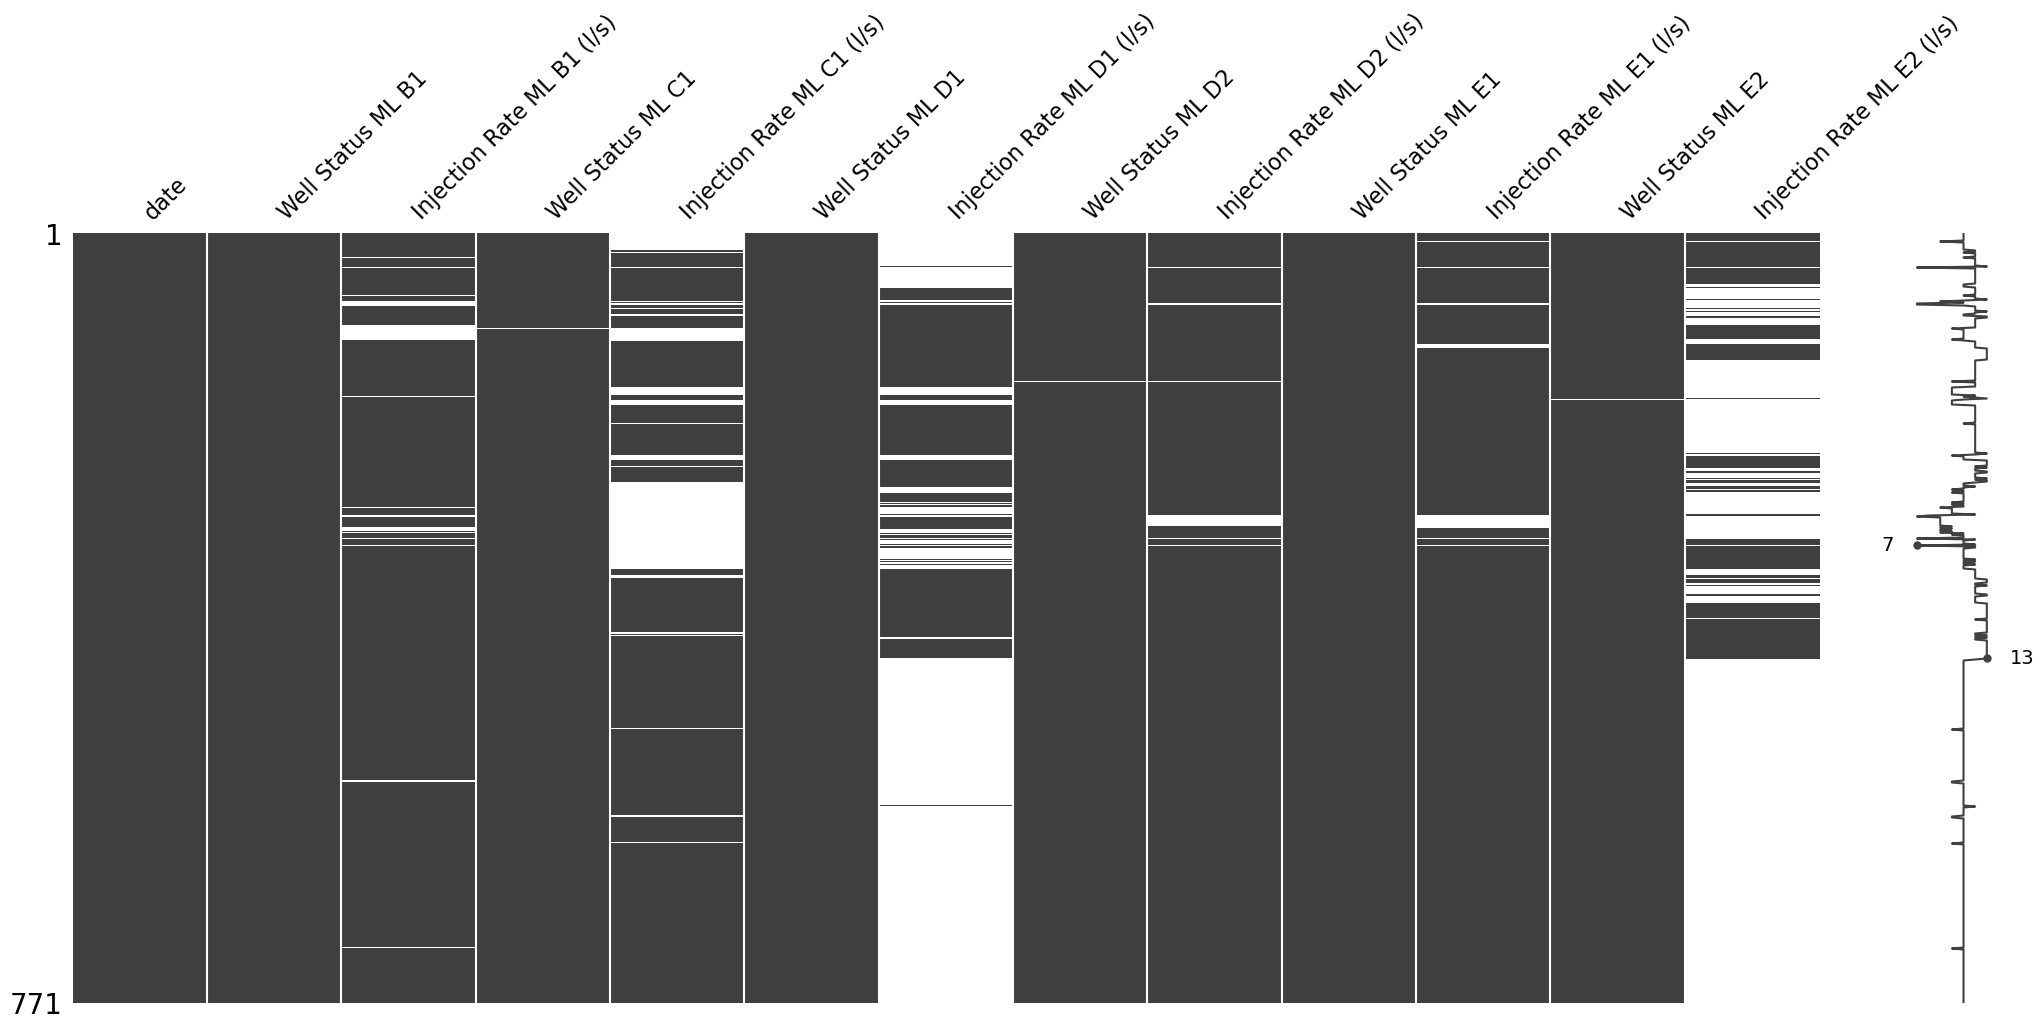

In [46]:
missingno.matrix(data)

Missing values in the numerical injection rate features for the particular well will be filled with 0, if the well status corresponds to the unique value 'Shut-in'.

In [47]:
well_status_columns = [
    "Well Status ML B1",
    "Well Status ML C1",
    "Well Status ML D1",
    "Well Status ML D2",
    "Well Status ML E1",
    "Well Status ML E2"
]

injection_rate_columns = [
    "Injection Rate ML B1 (l/s)",
    "Injection Rate ML C1 (l/s)",
    "Injection Rate ML D1 (l/s)",
    "Injection Rate ML D2 (l/s)",
    "Injection Rate ML E1 (l/s)",
    "Injection Rate ML E2 (l/s)"
]

# Loop through each well status and injection rate column
for status_col, rate_col in zip(well_status_columns, injection_rate_columns):
    # Filter dataframe based on well status column
    data_injecting = data[data[status_col] == "Injecting"]
    data_shutin = data[data[status_col] == "Shut-in"]

    # Fill missing value in the injection rate column with 0
    data_shutin[rate_col] = 0

    # Combined filtered dataframe with original dataframe
    data = data_injecting.append(data_shutin)


In [48]:
data

,date,Well Status ML B1,Injection Rate ML B1 (l/s),Well Status ML C1,Injection Rate ML C1 (l/s),Well Status ML D1,Injection Rate ML D1 (l/s),Well Status ML D2,Injection Rate ML D2 (l/s),Well Status ML E1,Injection Rate ML E1 (l/s),Well Status ML E2,Injection Rate ML E2 (l/s)
33,2021-02-03,Injecting,38.91,Injecting,1.7,Injecting,70.6,Injecting,99.5,Injecting,95.0,Injecting,31.0
66,2021-03-08,Injecting,33.55,Injecting,1.9,Injecting,56.2,Injecting,98.9,Injecting,65.0,Injecting,35.5
78,2021-03-20,Injecting,40.82,Injecting,1.8,Injecting,53.3,Injecting,136.5,Injecting,67.0,Injecting,45.2
83,2021-03-25,Injecting,37.81,Injecting,2.3,Injecting,52.5,Injecting,132.1,Injecting,67.0,Injecting,31.3
84,2021-03-26,Injecting,37.73,Injecting,1.9,Injecting,52.3,Injecting,147.3,Injecting,67.0,Injecting,23.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-10-17,Injecting,30.10,Shut-in,0.0,Injecting,72.8,Shut-in,0.0,Shut-in,0.0,Shut-in,0.0
290,2021-10-18,Injecting,31.00,Shut-in,0.0,Injecting,75.1,Shut-in,0.0,Shut-in,0.0,Shut-in,0.0
291,2021-10-19,Injecting,32.50,Shut-in,0.0,Injecting,73.7,Shut-in,0.0,Shut-in,0.0,Shut-in,0.0
292,2021-10-20,Injecting,32.10,Shut-in,0.0,Injecting,73.2,Shut-in,0.0,Shut-in,0.0,Shut-in,0.0


In [49]:
data = data.sort_index()
data

,date,Well Status ML B1,Injection Rate ML B1 (l/s),Well Status ML C1,Injection Rate ML C1 (l/s),Well Status ML D1,Injection Rate ML D1 (l/s),Well Status ML D2,Injection Rate ML D2 (l/s),Well Status ML E1,Injection Rate ML E1 (l/s),Well Status ML E2,Injection Rate ML E2 (l/s)
0,2021-01-01,Injecting,39.33,Shut-in,0.0,Shut-in,0.0,Injecting,95.4,Injecting,91.0,Injecting,40.0
1,2021-01-02,Injecting,39.33,Shut-in,0.0,Shut-in,0.0,Injecting,96.0,Injecting,91.0,Injecting,40.0
2,2021-01-03,Injecting,39.87,Shut-in,0.0,Shut-in,0.0,Injecting,95.4,Injecting,94.0,Injecting,40.0
3,2021-01-04,Injecting,37.57,Shut-in,0.0,Shut-in,0.0,Injecting,93.4,Injecting,94.0,Injecting,40.0
4,2021-01-05,Injecting,41.78,Shut-in,0.0,Shut-in,0.0,Injecting,75.1,Injecting,93.0,Injecting,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2023-05-23,Injecting,38.24,Injecting,1.6,Shut-in,0.0,Injecting,177.8,Injecting,113.0,Shut-in,0.0
767,2023-05-24,Injecting,38.26,Injecting,1.1,Shut-in,0.0,Injecting,125.3,Injecting,112.0,Shut-in,0.0
768,2023-05-25,Injecting,34.77,Injecting,1.2,Shut-in,0.0,Injecting,177.0,Injecting,113.0,Shut-in,0.0
769,2023-05-26,Injecting,35.48,Injecting,1.4,Shut-in,0.0,Injecting,177.9,Injecting,112.0,Shut-in,0.0


<Axes: >

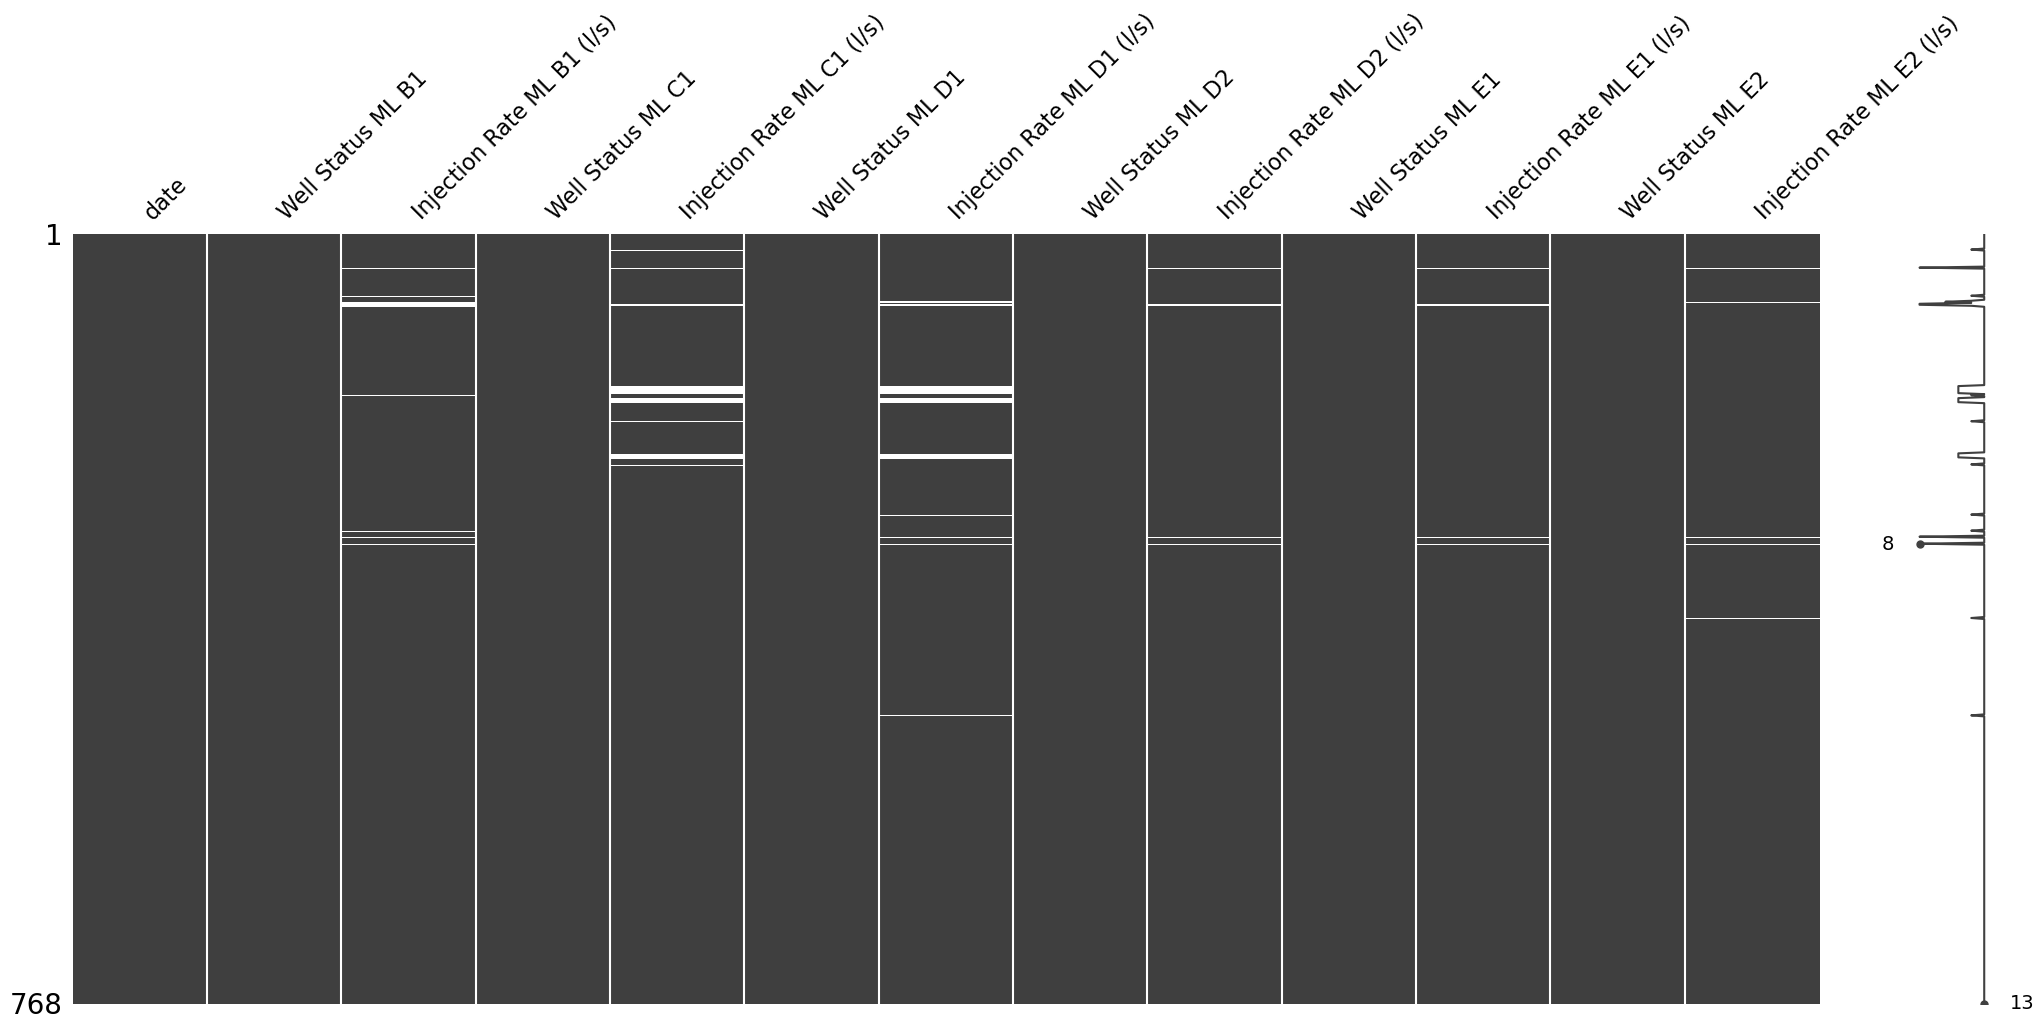

In [50]:
missingno.matrix(data)

In [51]:
data.isna().sum()/data.shape[0]*100

date                          0.000000
Well Status ML B1             0.000000
Injection Rate ML B1 (l/s)    1.432292
Well Status ML C1             0.000000
Injection Rate ML C1 (l/s)    3.125000
Well Status ML D1             0.000000
Injection Rate ML D1 (l/s)    3.385417
Well Status ML D2             0.000000
Injection Rate ML D2 (l/s)    0.651042
Well Status ML E1             0.000000
Injection Rate ML E1 (l/s)    0.651042
Well Status ML E2             0.000000
Injection Rate ML E2 (l/s)    0.651042
dtype: float64

The presence of missing values is below 5% for each feature

Similarly to the filling of missing values for the `MI Magnitude` and `Mw Magnitude` features, the filling of the numerical data injection rate features also uses KNN imputation technique.

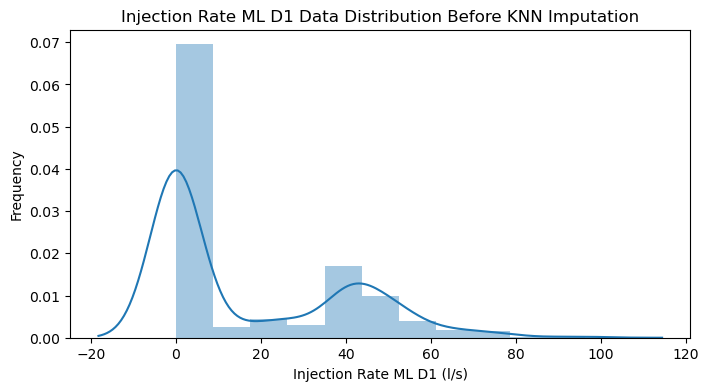

In [52]:
plt.figure(figsize=(8,4))
sns.distplot(data['Injection Rate ML D1 (l/s)'])
plt.xlabel('Injection Rate ML D1 (l/s)', size = 10)
plt.ylabel('Frequency', size = 10)
plt.title('Injection Rate ML D1 Data Distribution Before KNN Imputation')

plt.show()

In [53]:
# Select Numerical Column
numeric_columns = data.select_dtypes(include=['float64']).columns

# Implent KNNImputer 
imputer = KNNImputer(n_neighbors=4)

# Perform imputation on a DataFrame for numeric columns only
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

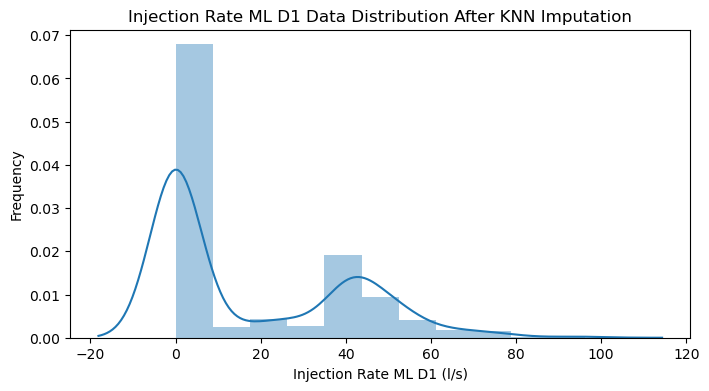

In [54]:
plt.figure(figsize=(8,4))
sns.distplot(data['Injection Rate ML D1 (l/s)'])
plt.xlabel('Injection Rate ML D1 (l/s)', size = 10)
plt.ylabel('Frequency', size = 10)
plt.title('Injection Rate ML D1 Data Distribution After KNN Imputation')

plt.show()

After filling in the missing values using the KNN imputation method, the data distribution of the feature `Injection rate ML D1 (l/s)` is still similar to the data distribution before the imputation method was applied, this indicates that the imputation technique was successful.

<Axes: >

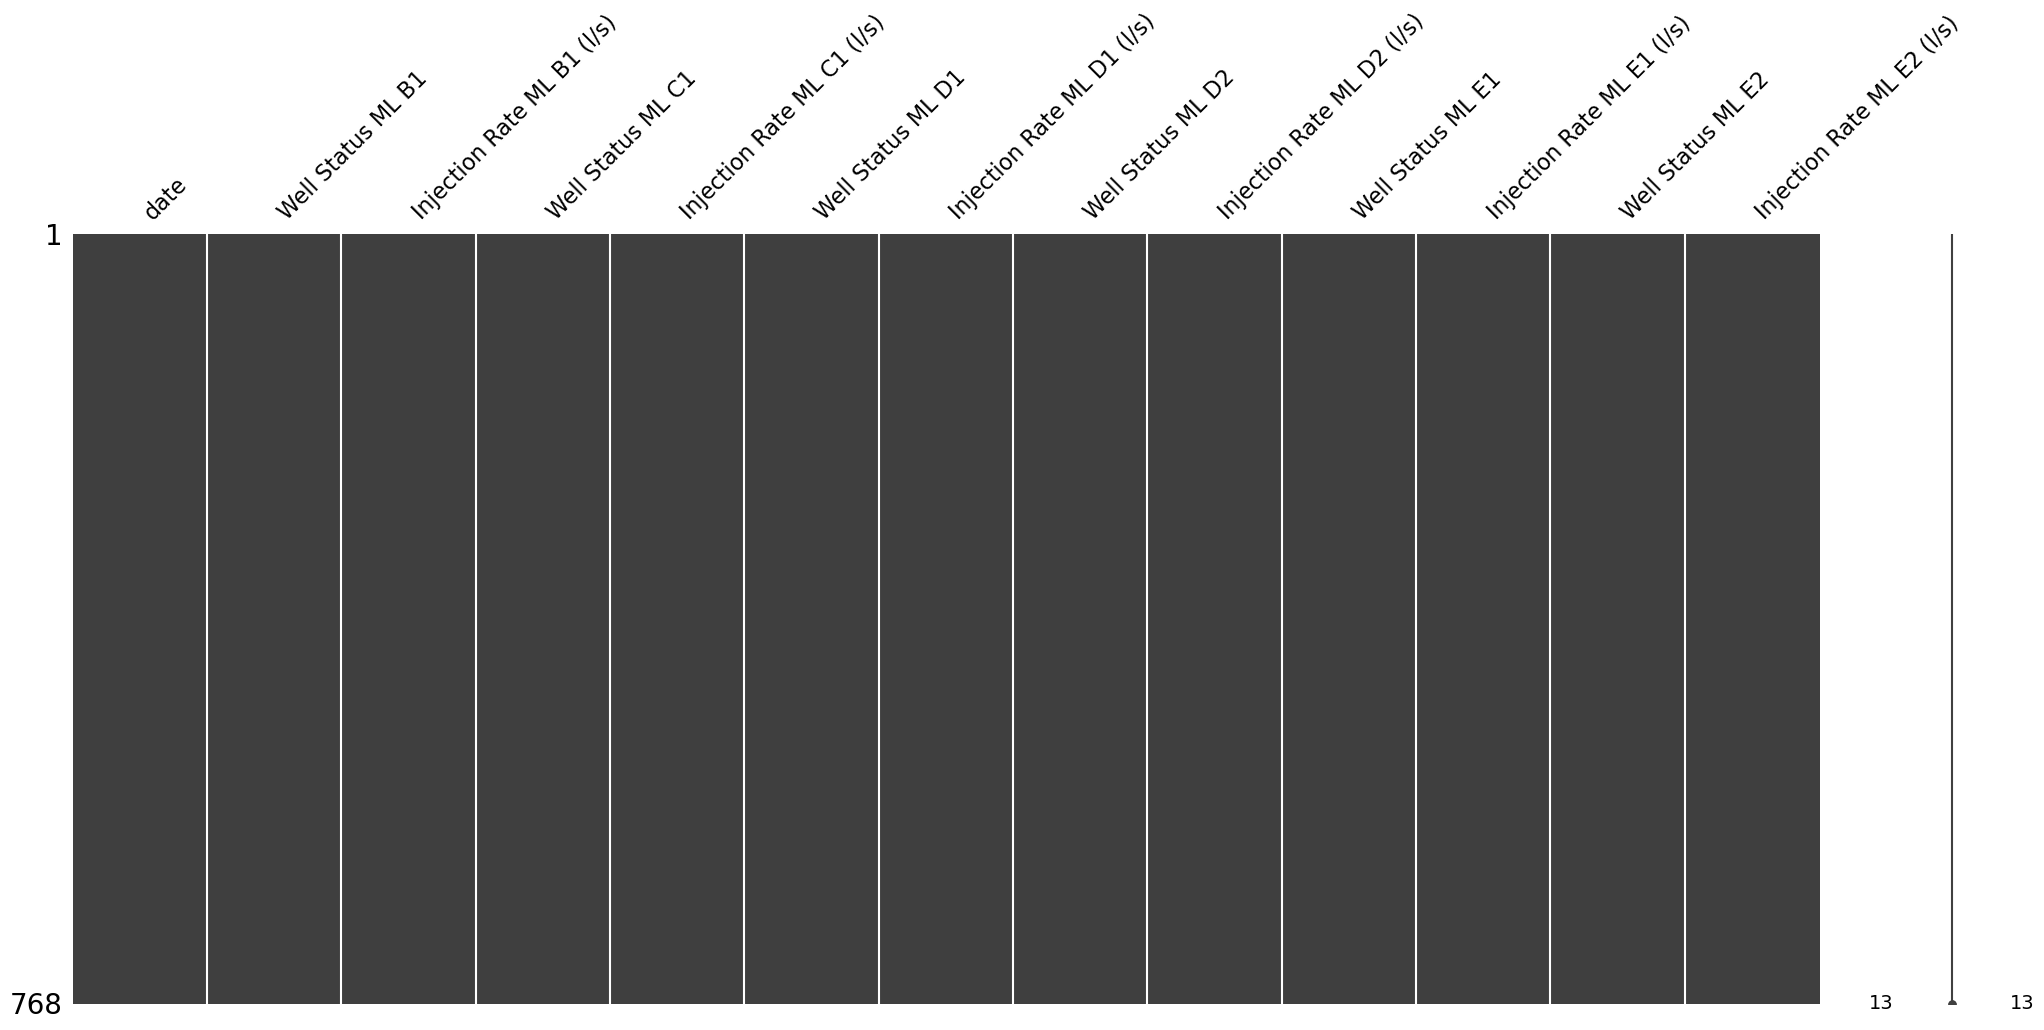

In [55]:
missingno.matrix(data)

Now that all of the injection well dataset has been cleaned.

Features that will not be used for data analysis needs will be dropped

In [56]:
# Drop the unwanted feature
data_unwanted_columns = [
    'Well Status ML B1',
    'Well Status ML C1',
    'Well Status ML D1',
    'Well Status ML D2',
    'Well Status ML E1',
    'Well Status ML E2'
]

data = data.drop(columns=data_unwanted_columns)

In [57]:
data

,date,Injection Rate ML B1 (l/s),Injection Rate ML C1 (l/s),Injection Rate ML D1 (l/s),Injection Rate ML D2 (l/s),Injection Rate ML E1 (l/s),Injection Rate ML E2 (l/s)
0,2021-01-01,39.33,0.0,0.0,95.4,91.0,40.0
1,2021-01-02,39.33,0.0,0.0,96.0,91.0,40.0
2,2021-01-03,39.87,0.0,0.0,95.4,94.0,40.0
3,2021-01-04,37.57,0.0,0.0,93.4,94.0,40.0
4,2021-01-05,41.78,0.0,0.0,75.1,93.0,40.0
...,...,...,...,...,...,...,...
766,2023-05-23,38.24,1.6,0.0,177.8,113.0,0.0
767,2023-05-24,38.26,1.1,0.0,125.3,112.0,0.0
768,2023-05-25,34.77,1.2,0.0,177.0,113.0,0.0
769,2023-05-26,35.48,1.4,0.0,177.9,112.0,0.0


## Wellhead Pressure Data

In [58]:
data_whp = pd.read_excel('WHP Well Jan 2021 - May 2023.xlsx') 
data_whp

,date,WHP ML B1 (barg),WHP ML C1 (barg),WHP ML D1 (barg),WHP ML D2 (barg),WHP ML E1 (barg),WHP ML E2 (barg)
0,2021-01-01,2.29,0.0,-0.71,5.75,19.34,19.64
1,2021-01-02,2.35,0.0,-0.69,6.11,19.12,19.44
2,2021-01-03,3.03,0.0,-0.68,6.36,19.65,20.04
3,2021-01-04,2.59,0.0,-0.66,6.05,19.72,20.10
4,2021-01-05,4.10,0.0,-0.65,3.35,19.54,19.92
...,...,...,...,...,...,...,...
766,2023-05-23,3.83,9.0,-0.76,16.10,21.62,-0.55
767,2023-05-24,3.81,9.0,-0.76,8.05,21.66,-0.55
768,2023-05-25,2.83,9.0,-0.77,16.02,21.75,-0.55
769,2023-05-26,2.82,9.0,-0.76,16.28,21.76,-0.55


In [59]:
data_whp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              771 non-null    datetime64[ns]
 1   WHP ML B1 (barg)  766 non-null    float64       
 2   WHP ML C1 (barg)  748 non-null    float64       
 3   WHP ML D1 (barg)  766 non-null    float64       
 4   WHP ML D2 (barg)  765 non-null    float64       
 5   WHP ML E1 (barg)  766 non-null    float64       
 6   WHP ML E2 (barg)  765 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 42.3 KB


* It can be seen that the wellhead pressure dataset from 01-21-2021 to 5-29-2023 has 7 columns and 771 rows.
* The WHP dataset has one column of type datetime followed 6 features of numerical type.

<Axes: >

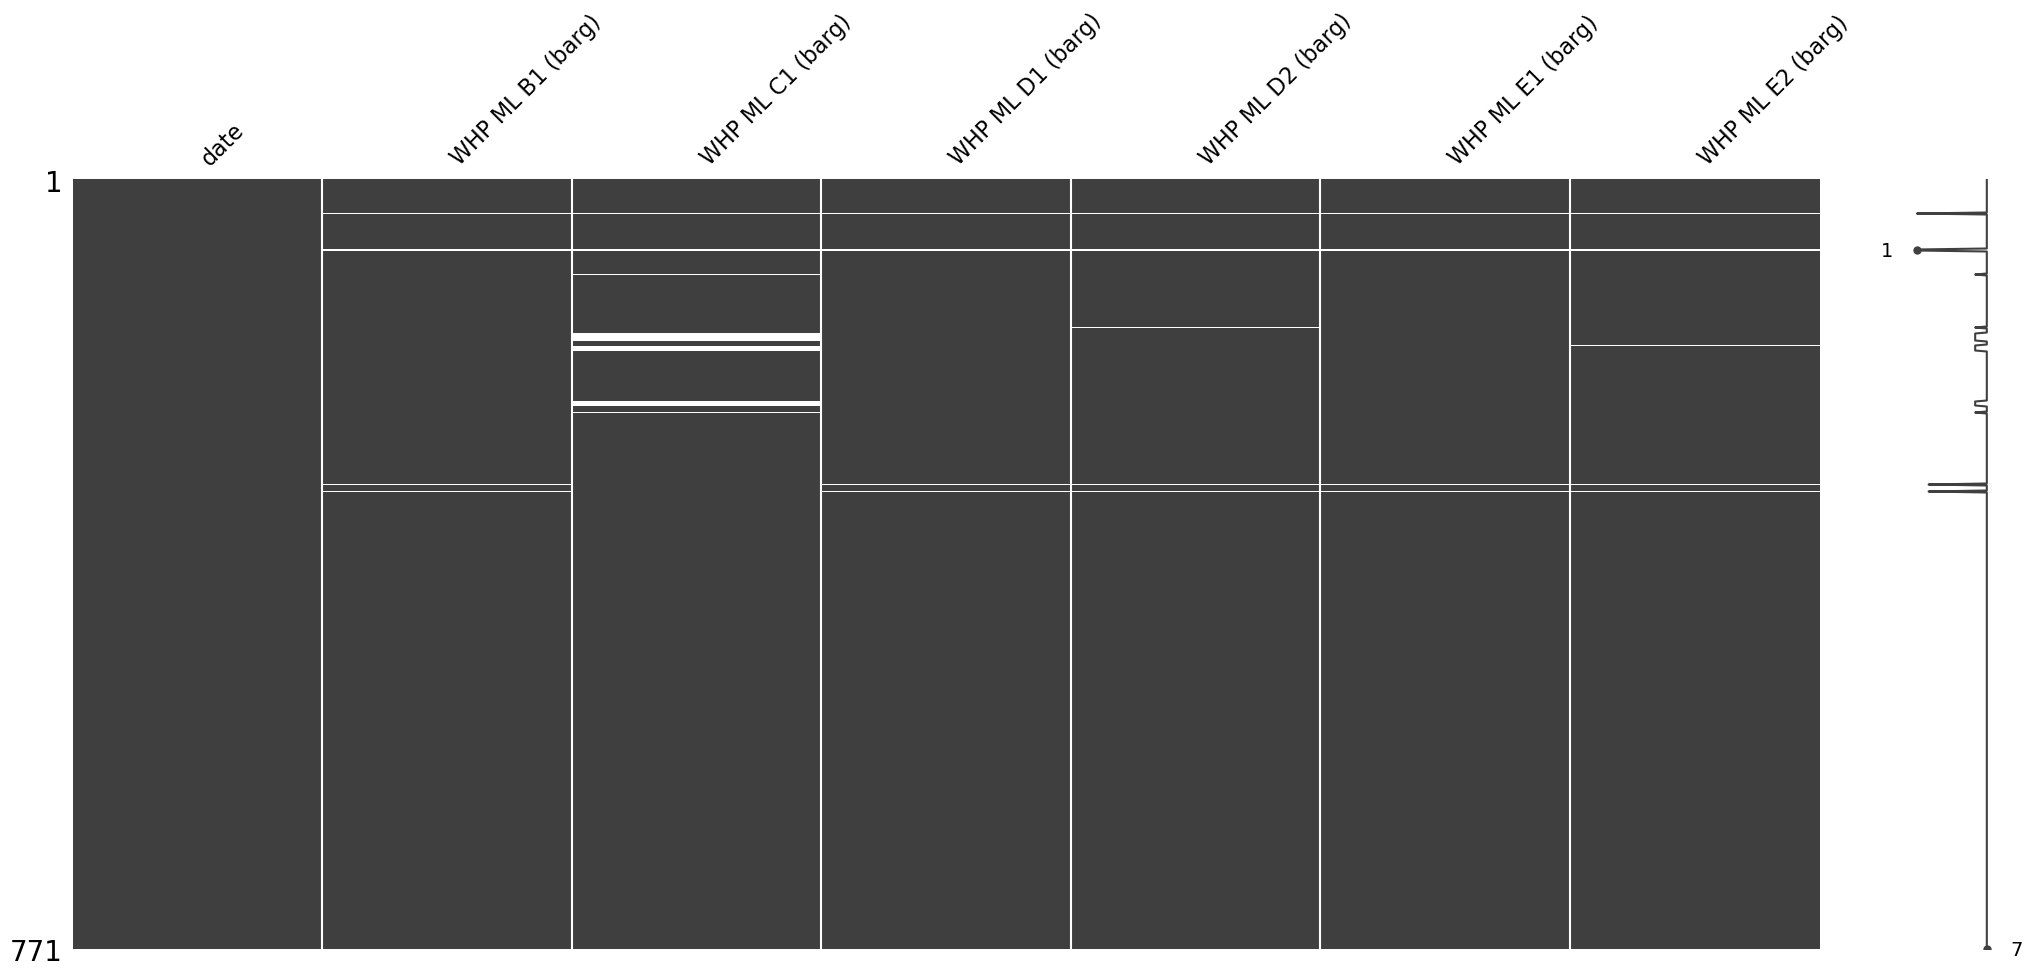

In [60]:
missingno.matrix(data_whp)

### Wellhead Pressure Data Cleaning

Missing values for the wellhead pressure dataset are imputed in the same way as for the size and injection rate features, using KNN imputation.

In [61]:
# Select Numerical Column
numeric_columns = data_whp.select_dtypes(include=['float64']).columns

# Implent KNNImputer 
imputer = KNNImputer(n_neighbors=4)

# Perform imputation on a DataFrame for numeric columns only
data_whp[numeric_columns] = imputer.fit_transform(data_whp[numeric_columns])

<Axes: >

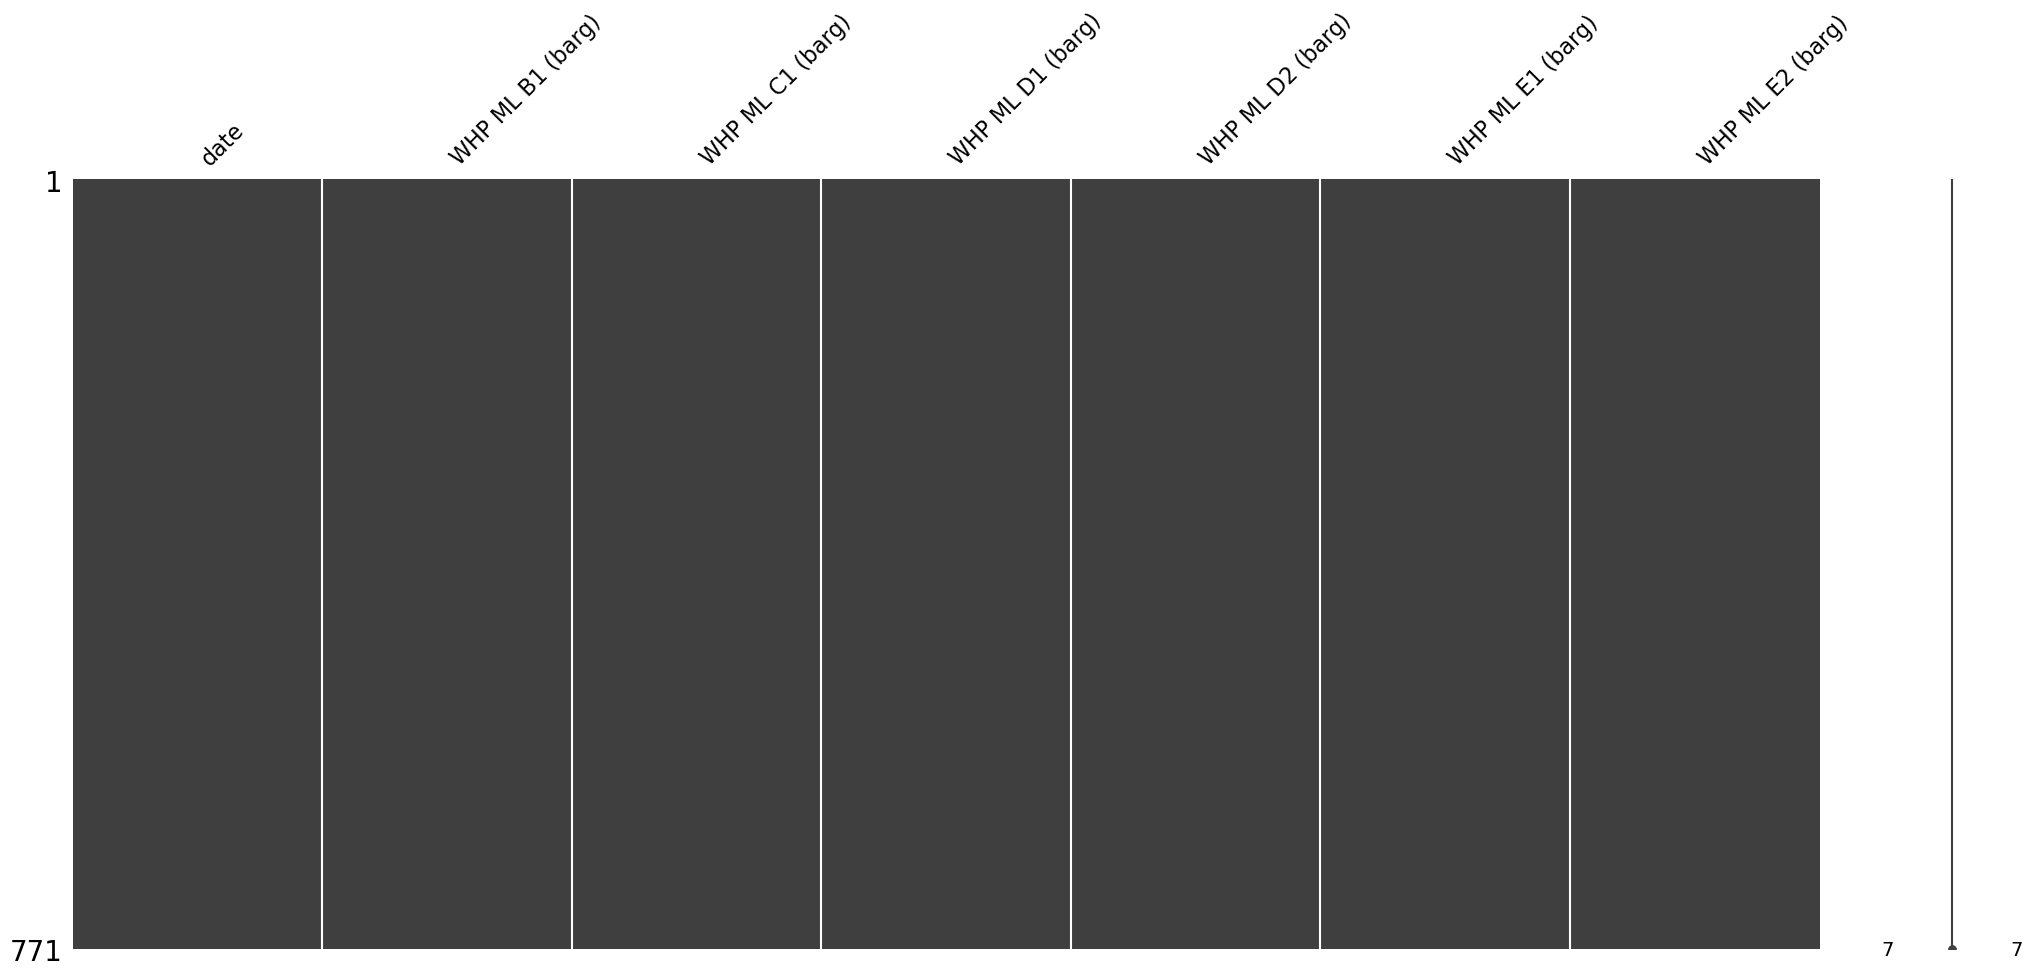

In [62]:
missingno.matrix(data_whp)

In [63]:
data_whp.describe()

,WHP ML B1 (barg),WHP ML C1 (barg),WHP ML D1 (barg),WHP ML D2 (barg),WHP ML E1 (barg),WHP ML E2 (barg)
count,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000
mean,3.784709,7.659929,8.356882,12.141870,17.203182,3.115452
std,1.663221,3.452719,11.606617,4.972722,4.351634,7.723001
min,-0.500000,0.000000,-0.810000,-0.350000,0.000000,-0.890000
25%,3.310000,8.500000,-0.740000,7.950000,13.070000,-0.660000
50%,4.020000,9.000000,-0.380000,13.800000,19.110000,-0.560000
75%,4.570000,9.500000,22.910000,16.075000,20.295000,-0.020000
max,12.800000,10.344828,28.000000,25.420000,25.100000,24.510000


* From 21.01.2021 to 29.05.2023, the ML E1 injection well had the highest average wellhead pressure of 17.203 (barg) and the highest injection rate value of 25.1 (barg).
* The passive ML C1 contributed an average of 7.65 (barg), approximately 50% more than the average of the ML B1 and ML E2 wellhead pressures for almost 2.5 years.

## Injection Temperature and FCV Data

Reservoir parameter data for injection temperature and flow control valves (FCV) are only available for wells B1, D2 and E1, so only these wells are analysed for injection temperature and FCV.

In [64]:
data_temp_fcv = pd.read_excel('Temperature FCV Well Jan 2021 - May 2023.xlsx') 
data_temp_fcv

,date,Well Status ML B1,Well Status ML D2,Well Status ML E1,Injection Temperature ML B1(Degree C),Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%)
0,2021-01-01,Injecting,Injecting,Injecting,35.0,144.7,198.1,8.0,22.7,17.7
1,2021-01-02,Injecting,Injecting,Injecting,35.0,144.6,198.0,8.0,22.7,17.7
2,2021-01-03,Injecting,Injecting,Injecting,33.0,144.7,197.9,7.8,22.7,17.7
3,2021-01-04,Injecting,Injecting,Injecting,35.0,144.8,198.1,7.5,22.7,17.7
4,2021-01-05,Injecting,Injecting,Injecting,34.0,146.3,198.0,12.0,22.7,17.7
...,...,...,...,...,...,...,...,...,...,...
766,2023-05-23,Injecting,Injecting,Injecting,39.0,148.6,194.9,17.9,33.0,21.7
767,2023-05-24,Injecting,Injecting,Injecting,39.0,145.9,194.8,18.0,33.0,21.7
768,2023-05-25,Injecting,Injecting,Injecting,39.0,148.6,194.9,15.9,33.0,21.7
769,2023-05-26,Injecting,Injecting,Injecting,39.0,148.5,194.9,16.0,33.0,21.7


In [65]:
data_temp_fcv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   771 non-null    datetime64[ns]
 1   Well Status ML B1                      771 non-null    object        
 2   Well Status ML D2                      770 non-null    object        
 3   Well Status ML E1                      771 non-null    object        
 4   Injection Temperature ML B1(Degree C)  709 non-null    float64       
 5   Injection Temperature ML D2(Degree C)  754 non-null    float64       
 6   Injection Temperature ML E1(Degree C)  748 non-null    float64       
 7   FCV Opening ML B1 (%)                  713 non-null    float64       
 8   FCV Opening ML D2 (%)                  754 non-null    float64       
 9   FCV Opening ML E1 (%)                  748 non-null    float64   

In [66]:
data_temp_fcv.columns

Index(['date', 'Well Status ML B1', 'Well Status ML D2', 'Well Status ML E1',
       'Injection Temperature ML B1(Degree C)',
       'Injection Temperature ML D2(Degree C)',
       'Injection Temperature ML E1(Degree C)', 'FCV Opening ML B1 (%)',
       'FCV Opening ML D2 (%)', 'FCV Opening ML E1 (%)'],
      dtype='object')

* It can be seen that the reservoir injection temperature and FCV dataset from 01-21-2021 to 5-29-2023 has 10 columns and 771 rows.
* The injection rate dataset has one column of type datetime, 3 features of type object and 6 features of numerical type.

### Injection Temprature and FCV Data Cleaning

In [67]:
categoric_data = data_temp_fcv.select_dtypes(include="object")

column = categoric_data.columns
unique = [categoric_data[i].unique() for i in column]
n_unique = [len(categoric_data[i].unique()) for i in column]

pd.DataFrame({
    'column': column,
    'n_unique': n_unique,
    'unique': unique
})

,column,n_unique,unique
0,Well Status ML B1,3,"[Injecting, Shut-in, Shut-In]"
1,Well Status ML D2,3,"[Injecting, nan, Shut-in]"
2,Well Status ML E1,2,"[Injecting, Shut-in]"


There is inconsistency in writing, therefore it will be only two unique values, namely 'Injecting' and 'Shut-in'.

In [68]:
data_temp_fcv["Well Status ML B1"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)
data_temp_fcv["Well Status ML D2"].replace(to_replace=["Shut-In", "shut-in"], value="Shut-in", regex=True, inplace=True)

Missing values in the numerical injection rate features for the particular well will be filled with 0, if the well status corresponds to the unique value 'Shut-in'.

In [69]:
well_status_columns = [
    "Well Status ML B1",
    "Well Status ML D2"
]


temp_fcv_columns = [
    "Injection Temperature ML B1(Degree C)",
    "Injection Temperature ML D2(Degree C)",
    "FCV Opening ML B1 (%)",
    "FCV Opening ML D2 (%)"
]

# Loop through each well status and injection rate column
for status_col, rate_col in zip(well_status_columns, temp_fcv_columns):
    # Filter dataframe based on well status column
    data_injecting = data_temp_fcv[data_temp_fcv[status_col] == "Injecting"]
    data_shutin = data_temp_fcv[data_temp_fcv[status_col] == "Shut-in"]

    # Fill missing value in the injection rate column with 0
    data_shutin[rate_col] = 0

    # Combined filtered dataframe with original dataframe
    data_temp_fcv = data_injecting.append(data_shutin)


In [70]:
data_temp_fcv = data_temp_fcv.sort_index()
data_temp_fcv

,date,Well Status ML B1,Well Status ML D2,Well Status ML E1,Injection Temperature ML B1(Degree C),Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%)
0,2021-01-01,Injecting,Injecting,Injecting,35.0,144.7,198.1,8.0,22.7,17.7
1,2021-01-02,Injecting,Injecting,Injecting,35.0,144.6,198.0,8.0,22.7,17.7
2,2021-01-03,Injecting,Injecting,Injecting,33.0,144.7,197.9,7.8,22.7,17.7
3,2021-01-04,Injecting,Injecting,Injecting,35.0,144.8,198.1,7.5,22.7,17.7
4,2021-01-05,Injecting,Injecting,Injecting,34.0,146.3,198.0,12.0,22.7,17.7
...,...,...,...,...,...,...,...,...,...,...
766,2023-05-23,Injecting,Injecting,Injecting,39.0,148.6,194.9,17.9,33.0,21.7
767,2023-05-24,Injecting,Injecting,Injecting,39.0,145.9,194.8,18.0,33.0,21.7
768,2023-05-25,Injecting,Injecting,Injecting,39.0,148.6,194.9,15.9,33.0,21.7
769,2023-05-26,Injecting,Injecting,Injecting,39.0,148.5,194.9,16.0,33.0,21.7


<Axes: >

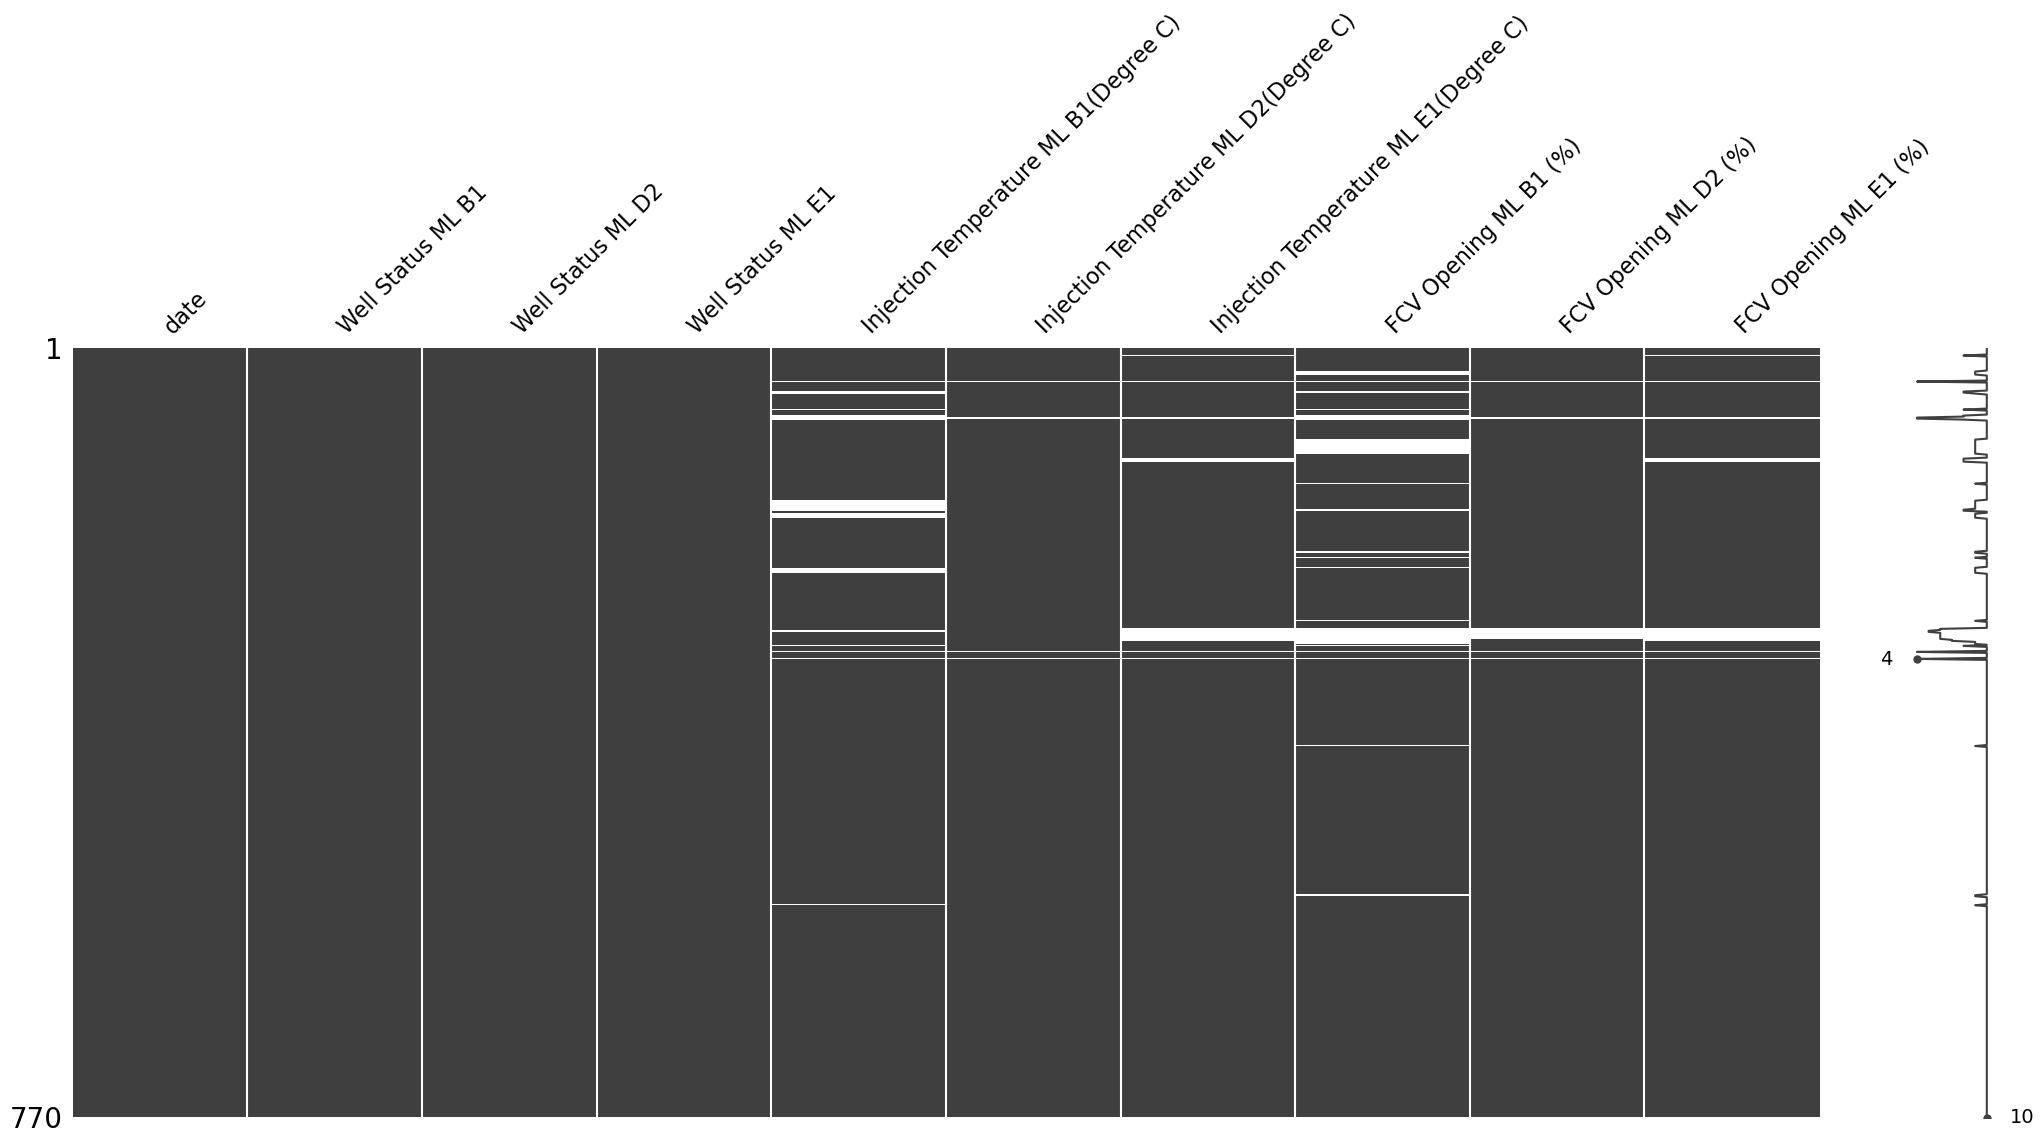

In [71]:
missingno.matrix(data_temp_fcv)

Missing values for the injection temperature and FCV dataset are imputed in the same way using KNN imputation.

In [72]:
# Select Numerical Column
numeric_columns = data_temp_fcv.select_dtypes(include=['float64']).columns

# Implent KNNImputer 
imputer = KNNImputer(n_neighbors=4)

# Perform imputation on a DataFrame for numeric columns only
data_temp_fcv[numeric_columns] = imputer.fit_transform(data_temp_fcv[numeric_columns])

<Axes: >

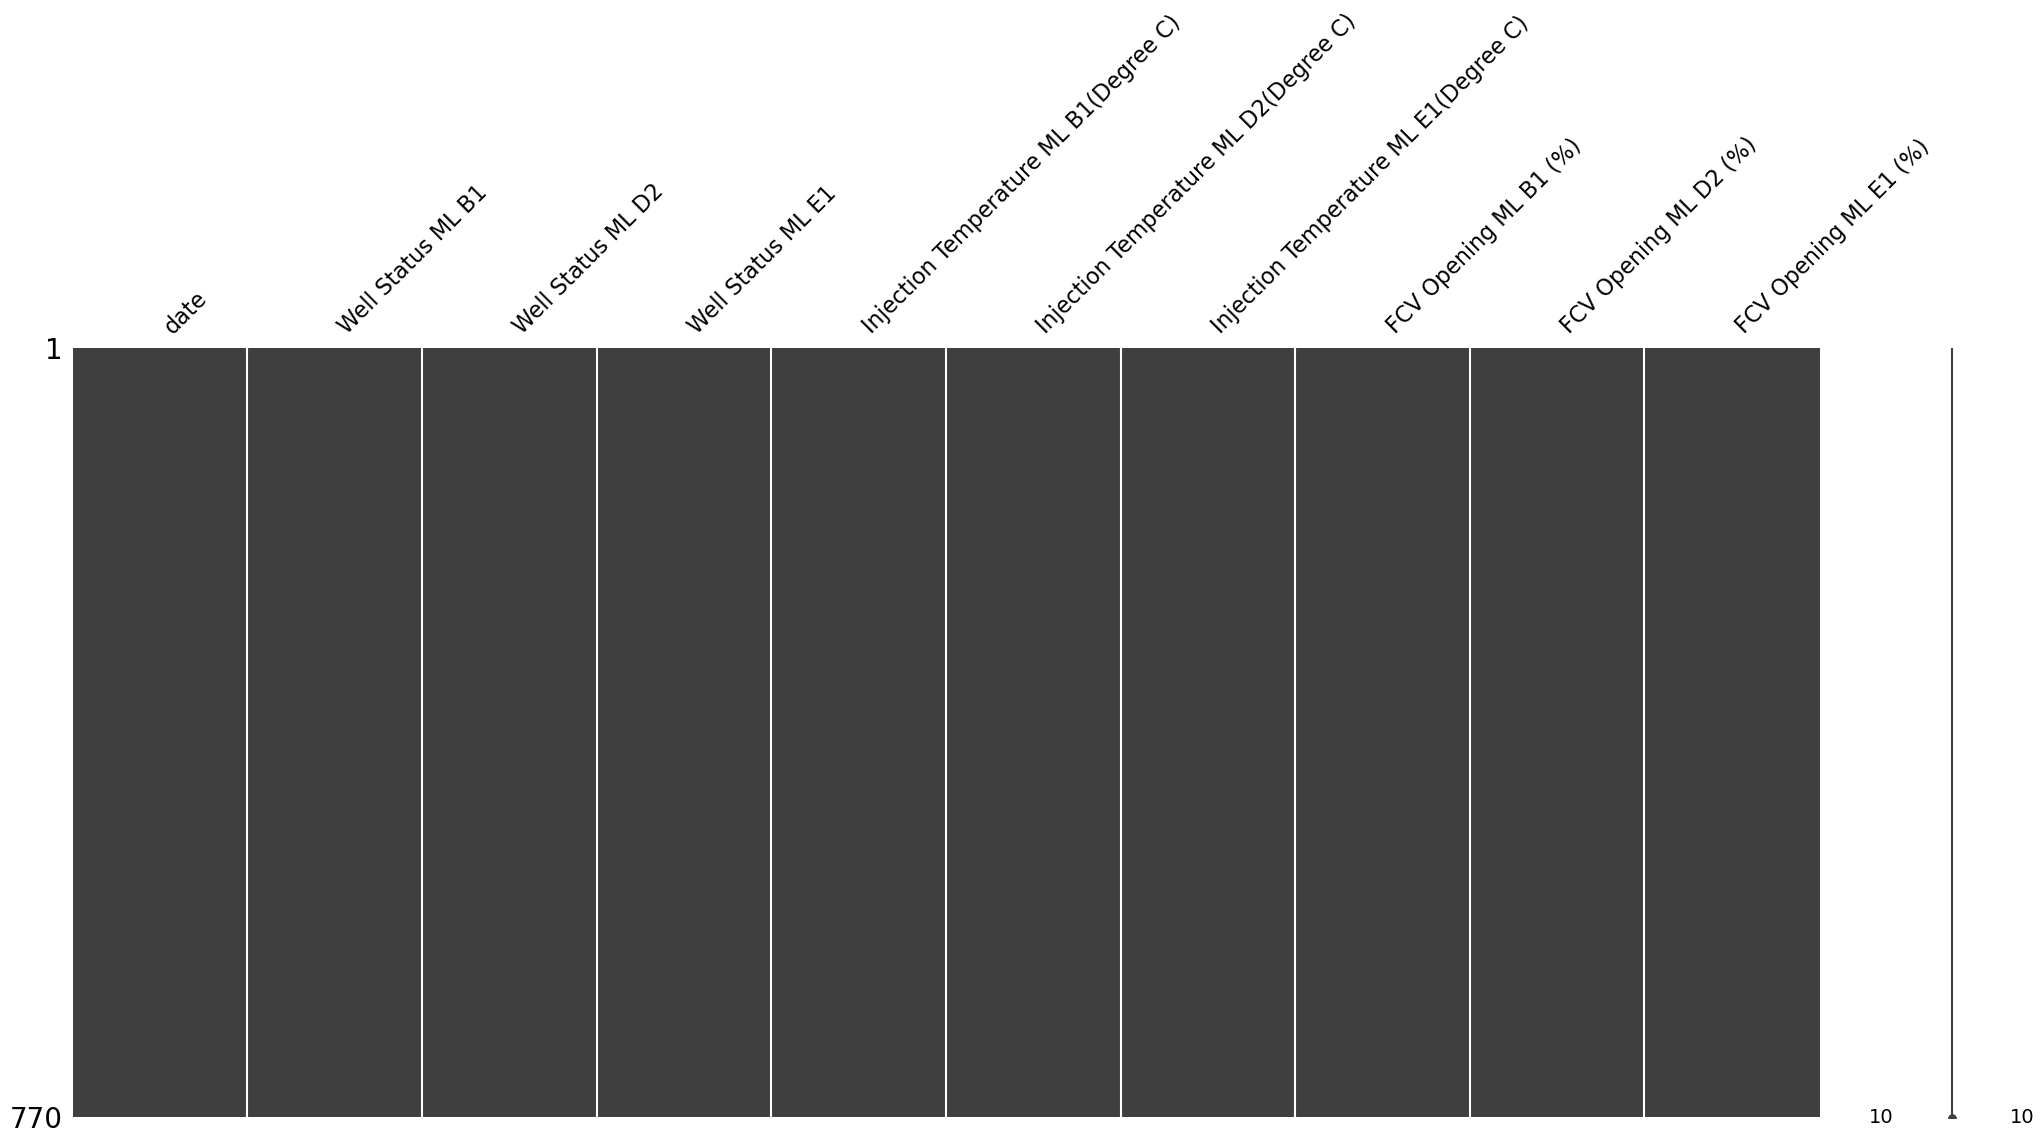

In [73]:
missingno.matrix(data_temp_fcv)

In [74]:
data_temp_fcv.describe(include=['O'])

,Well Status ML B1,Well Status ML D2,Well Status ML E1
count,770,770,770
unique,2,2,2
top,Injecting,Injecting,Injecting
freq,743,759,752


Features that will not be used for data analysis needs will be dropped

In [75]:
data_unwanted_columns = [
    'Well Status ML B1',
    'Well Status ML D2',
    'Well Status ML E1'
]

data_temp_fcv = data_temp_fcv.drop(columns=data_unwanted_columns)

In [76]:
data_temp_fcv

,date,Injection Temperature ML B1(Degree C),Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%)
0,2021-01-01,35.0,144.7,198.1,8.0,22.7,17.7
1,2021-01-02,35.0,144.6,198.0,8.0,22.7,17.7
2,2021-01-03,33.0,144.7,197.9,7.8,22.7,17.7
3,2021-01-04,35.0,144.8,198.1,7.5,22.7,17.7
4,2021-01-05,34.0,146.3,198.0,12.0,22.7,17.7
...,...,...,...,...,...,...,...
766,2023-05-23,39.0,148.6,194.9,17.9,33.0,21.7
767,2023-05-24,39.0,145.9,194.8,18.0,33.0,21.7
768,2023-05-25,39.0,148.6,194.9,15.9,33.0,21.7
769,2023-05-26,39.0,148.5,194.9,16.0,33.0,21.7


In [77]:
data_temp_fcv.describe()

,Injection Temperature ML B1(Degree C),Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%)
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,35.288673,145.251752,194.537414,15.102416,32.724461,19.404018
std,7.422171,17.554157,1.840148,4.746237,4.710914,5.058817
min,0.000000,0.000000,180.000000,0.000000,18.700000,0.000000
25%,35.500000,147.000000,194.700000,12.000000,31.575000,16.700000
50%,36.500000,147.900000,194.900000,15.500000,33.000000,21.100000
75%,37.000000,148.200000,195.400000,18.000000,33.000000,22.100000
max,61.500000,148.800000,198.100000,35.000000,50.800000,27.100000


* From 21.01.2021 to 29.05.2023, the ML E1 injection well had the highest average injection temperature of 194.537 celcius and the highest injection temperature value of 198.1 celcius.
* In addition, the ML D2 showed the highest average of the FCV percentage of 32.72% and maximum FCV opening of 50.8%

### Summary Reservoir Data Descriptive Statistics

- ML E1 was identified as the well with the highest average of injection temperature and WHP.
- Compared to the other wells, ML D2 was the highest in average injection rate and the highest in average FCV opening percentage.

# Microseismicity and Reservoir Data Manipulation and Analysis

This section combines microseismic and reservoir data from January 2021 to May 2023 for integrated data analysis, due to operational reservoir parameter data is only available in that time period.

In [78]:
result_merge = pd.merge(data, data_whp, on='date')
result_merge = pd.merge(result_merge, data_temp_fcv, on='date')
result_merge = pd.merge(result_merge, df2, on='date')
result_merge

,date,Injection Rate ML B1 (l/s),Injection Rate ML C1 (l/s),Injection Rate ML D1 (l/s),Injection Rate ML D2 (l/s),Injection Rate ML E1 (l/s),Injection Rate ML E2 (l/s),WHP ML B1 (barg),WHP ML C1 (barg),WHP ML D1 (barg),...,Injection Temperature ML D2(Degree C),Injection Temperature ML E1(Degree C),FCV Opening ML B1 (%),FCV Opening ML D2 (%),FCV Opening ML E1 (%),total_meq_events,cum_sum_meq_event,year,month,day
0,2021-01-01,39.33,0.0,0.0,95.4,91.0,40.0,2.29,0.0,-0.71,...,144.7,198.1,8.0,22.7,17.7,0,635,2021,1,1
1,2021-01-02,39.33,0.0,0.0,96.0,91.0,40.0,2.35,0.0,-0.69,...,144.6,198.0,8.0,22.7,17.7,1,636,2021,1,2
2,2021-01-03,39.87,0.0,0.0,95.4,94.0,40.0,3.03,0.0,-0.68,...,144.7,197.9,7.8,22.7,17.7,0,636,2021,1,3
3,2021-01-04,37.57,0.0,0.0,93.4,94.0,40.0,2.59,0.0,-0.66,...,144.8,198.1,7.5,22.7,17.7,0,636,2021,1,4
4,2021-01-05,41.78,0.0,0.0,75.1,93.0,40.0,4.10,0.0,-0.65,...,146.3,198.0,12.0,22.7,17.7,7,643,2021,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2023-05-23,38.24,1.6,0.0,177.8,113.0,0.0,3.83,9.0,-0.76,...,148.6,194.9,17.9,33.0,21.7,0,1139,2023,5,23
760,2023-05-24,38.26,1.1,0.0,125.3,112.0,0.0,3.81,9.0,-0.76,...,145.9,194.8,18.0,33.0,21.7,0,1139,2023,5,24
761,2023-05-25,34.77,1.2,0.0,177.0,113.0,0.0,2.83,9.0,-0.77,...,148.6,194.9,15.9,33.0,21.7,2,1141,2023,5,25
762,2023-05-26,35.48,1.4,0.0,177.9,112.0,0.0,2.82,9.0,-0.76,...,148.5,194.9,16.0,33.0,21.7,0,1141,2023,5,26


In [79]:
result_merge.columns

Index(['date', 'Injection Rate ML B1 (l/s)', 'Injection Rate ML C1 (l/s)',
       'Injection Rate ML D1 (l/s)', 'Injection Rate ML D2 (l/s)',
       'Injection Rate ML E1 (l/s)', 'Injection Rate ML E2 (l/s)',
       'WHP ML B1 (barg)', 'WHP ML C1 (barg)', 'WHP ML D1 (barg)',
       'WHP ML D2 (barg)', 'WHP ML E1 (barg)', 'WHP ML E2 (barg)',
       'Injection Temperature ML B1(Degree C)',
       'Injection Temperature ML D2(Degree C)',
       'Injection Temperature ML E1(Degree C)', 'FCV Opening ML B1 (%)',
       'FCV Opening ML D2 (%)', 'FCV Opening ML E1 (%)', 'total_meq_events',
       'cum_sum_meq_event', 'year', 'month', 'day'],
      dtype='object')

<Axes: >

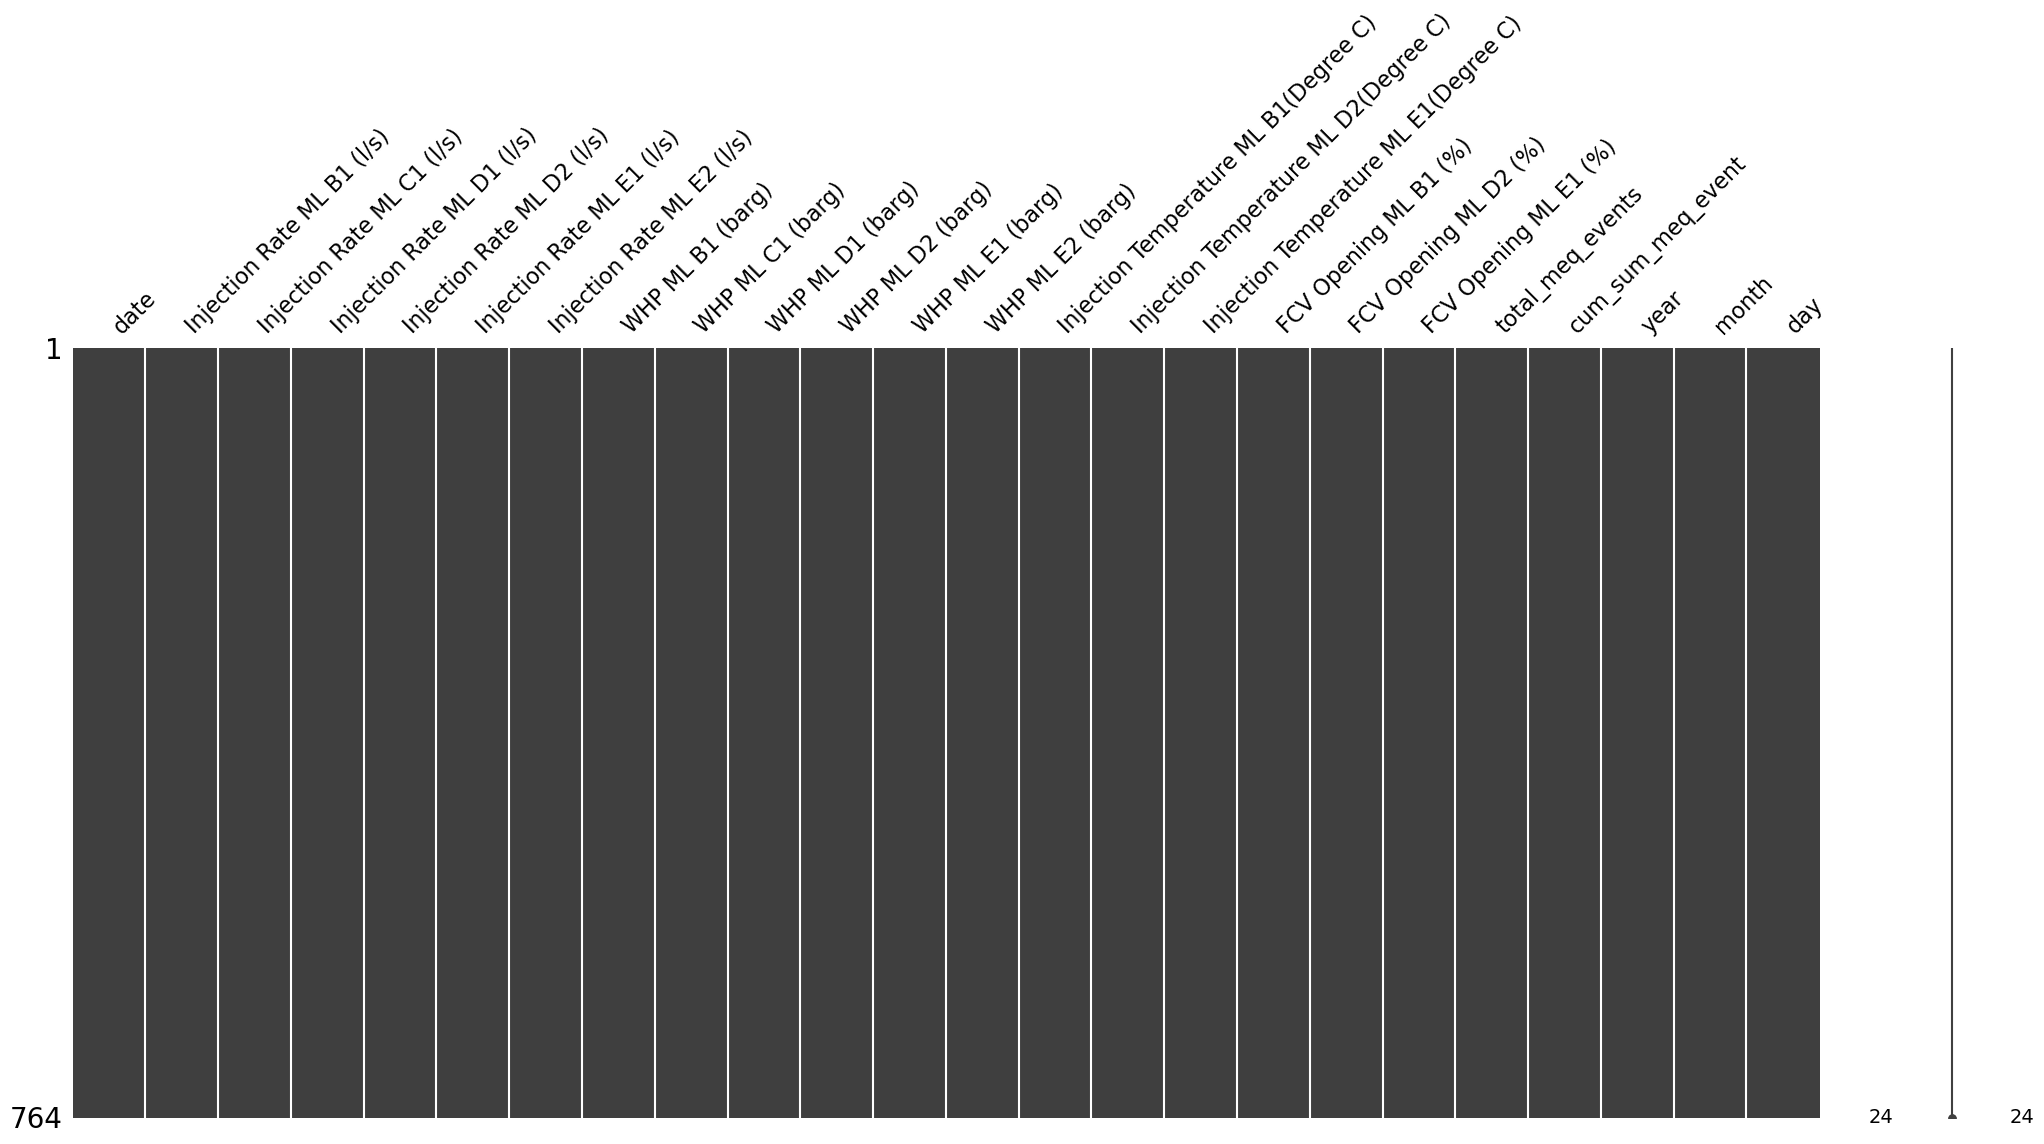

In [80]:
missingno.matrix(result_merge)

In [81]:
result_merge.isna().sum()/df.shape[0]*100

date                                     0.0
Injection Rate ML B1 (l/s)               0.0
Injection Rate ML C1 (l/s)               0.0
Injection Rate ML D1 (l/s)               0.0
Injection Rate ML D2 (l/s)               0.0
Injection Rate ML E1 (l/s)               0.0
Injection Rate ML E2 (l/s)               0.0
WHP ML B1 (barg)                         0.0
WHP ML C1 (barg)                         0.0
WHP ML D1 (barg)                         0.0
WHP ML D2 (barg)                         0.0
WHP ML E1 (barg)                         0.0
WHP ML E2 (barg)                         0.0
Injection Temperature ML B1(Degree C)    0.0
Injection Temperature ML D2(Degree C)    0.0
Injection Temperature ML E1(Degree C)    0.0
FCV Opening ML B1 (%)                    0.0
FCV Opening ML D2 (%)                    0.0
FCV Opening ML E1 (%)                    0.0
total_meq_events                         0.0
cum_sum_meq_event                        0.0
year                                     0.0
month     

In [82]:
# Save to file Excel
#result_merge.to_excel('Data MEQ and Reservoir Jan 2021 - May 2023.xlsx', index=False)

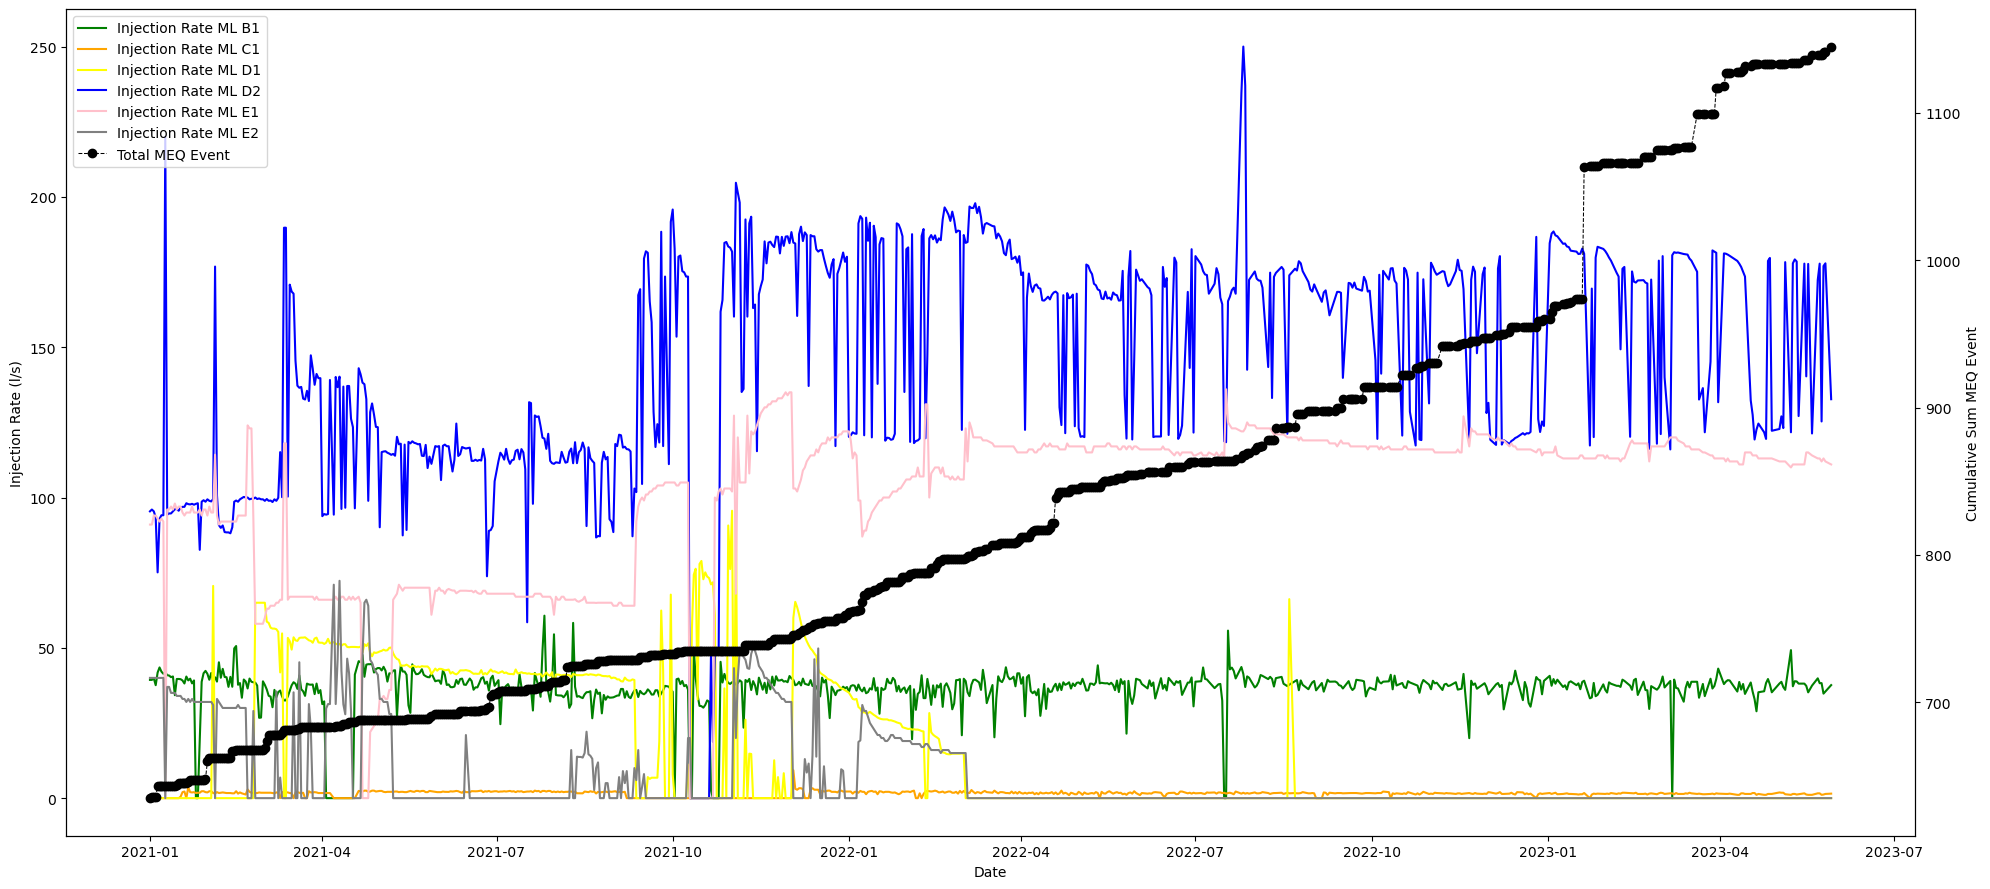

In [83]:
# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(20, 9))

# Plot the first set of data (Injection Rate) on the first y-axis (ax1)
ax1.plot(result_merge['date'], result_merge['Injection Rate ML B1 (l/s)'], color='green', label='Injection Rate ML B1')
ax1.plot(result_merge['date'], result_merge['Injection Rate ML C1 (l/s)'], color='orange', label='Injection Rate ML C1')
ax1.plot(result_merge['date'], result_merge['Injection Rate ML D1 (l/s)'], color='yellow', label='Injection Rate ML D1')
ax1.plot(result_merge['date'], result_merge['Injection Rate ML D2 (l/s)'], color='blue', label='Injection Rate ML D2')
ax1.plot(result_merge['date'], result_merge['Injection Rate ML E1 (l/s)'], color='pink',label='Injection Rate ML E1')
ax1.plot(result_merge['date'], result_merge['Injection Rate ML E2 (l/s)'], color='grey',label='Injection Rate ML E2')

# Set the label and color for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Injection Rate (l/s)', color='black')

# Create a second y-axis for the second plot
ax2 = ax1.twinx()

# Plot the second set of data (Total MEQ Event) on the second y-axis (ax2)
ax2.plot(result_merge['date'], result_merge['cum_sum_meq_event'], linewidth=0.75, marker='o', linestyle='--', color='black', label='Total MEQ Event')

# Set the label and color for the second y-axis
ax2.set_ylabel('Cumulative Sum MEQ Event')

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Set the title and adjust layout
#plt.title('Injection Rate vs. Total MEQ Event Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


Induced seismicity is triggered by hydraulic effects shortly after the start of fluid injection (in days to months) and by thermoelastic effects over longer periods (in months to years) (Izadi and Elsworth, 2015).

From the visualisation of the injection rate plot and cumulative microseismic events from January 2021 to May 2023, it can be seen that the MEQ events continue to be intense after the first quarter of 2022 and experience a significant increase in the first quarter of 2023. During this period, the ML D2 brine well injected brine in the range of +- 125 l/s to +- 200 l/s and the ML E1 brine well injected brine in the range of +- 120 l/s to +- 130 l/s.

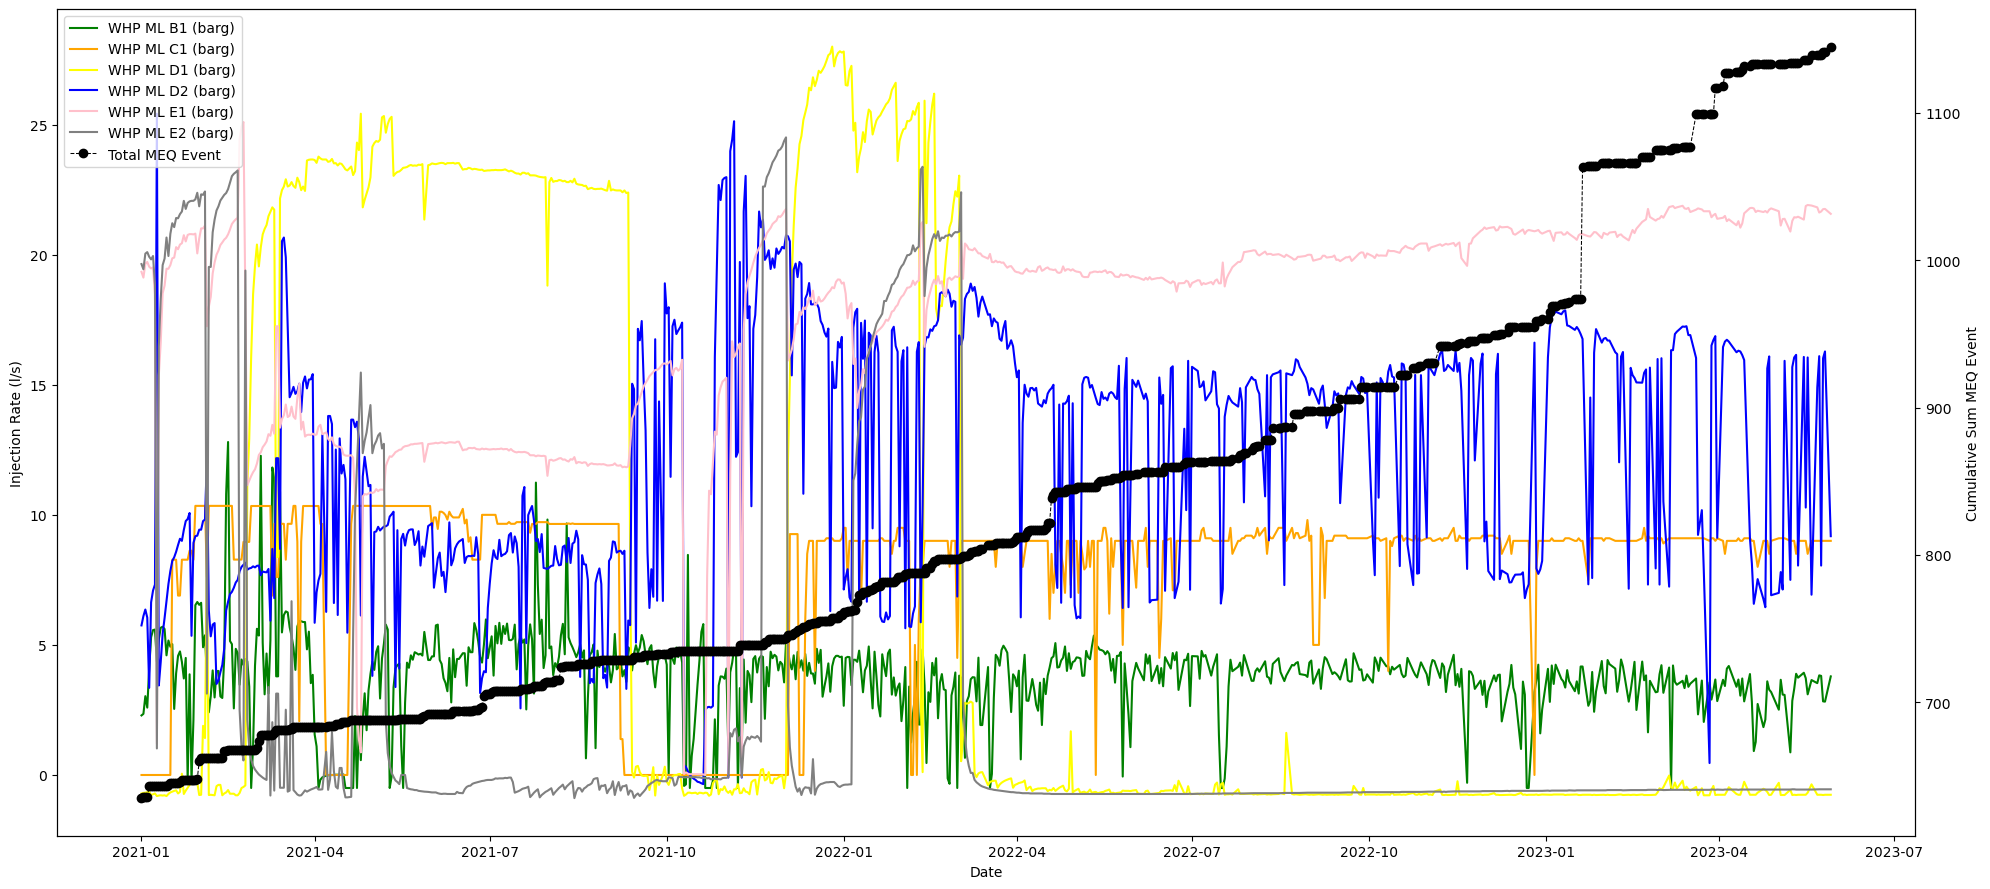

In [84]:
# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(20, 9))

# Plot the first set of data (WHP) on the first y-axis (ax1)
ax1.plot(result_merge['date'], result_merge['WHP ML B1 (barg)'], color='green', label='WHP ML B1 (barg)')
ax1.plot(result_merge['date'], result_merge['WHP ML C1 (barg)'], color='orange', label='WHP ML C1 (barg)')
ax1.plot(result_merge['date'], result_merge['WHP ML D1 (barg)'], color='yellow', label='WHP ML D1 (barg)')
ax1.plot(result_merge['date'], result_merge['WHP ML D2 (barg)'], color='blue', label='WHP ML D2 (barg)')
ax1.plot(result_merge['date'], result_merge['WHP ML E1 (barg)'], color='pink',label='WHP ML E1 (barg)')
ax1.plot(result_merge['date'], result_merge['WHP ML E2 (barg)'], color='grey',label='WHP ML E2 (barg)')

# Set the label and color for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Injection Rate (l/s)', color='black')

# Create a second y-axis for the second plot
ax2 = ax1.twinx()

# Plot the second set of data (Total MEQ Event) on the second y-axis (ax2)
ax2.plot(result_merge['date'], result_merge['cum_sum_meq_event'], linewidth=0.75, marker='o', linestyle='--', color='black', label='Total MEQ Event')

# Set the label and color for the second y-axis
ax2.set_ylabel('Cumulative Sum MEQ Event')

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Set the title and adjust layout
#plt.title('Injection Rate vs. Total MEQ Event Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


Increased wellhead pressure could plausibly be associated with microseismicity in the same way as injection rate. For example, high injection pressure could increase pressure volume or pressure rate, both of which are associated with fault stability conditions and earthquake triggering (Catalli et al., 2016; Ciardo & Rinaldi, 2022; Dempsey & Riffault, 2019; Hubbert & Rubey, 1959).

The intensity of microseismicity increased after the first quarter of 2022 and increased dramatically in the first quarter of 2023. This is consistent with the wellhead pressures of ML D1 and ML E2 being reduced to the maximum, while ML E1 was increased to the range of 19 - 22 barg and D2 was reduced from the range of 25 to 17 barg and maintained in the range of 7 - 17 barg.

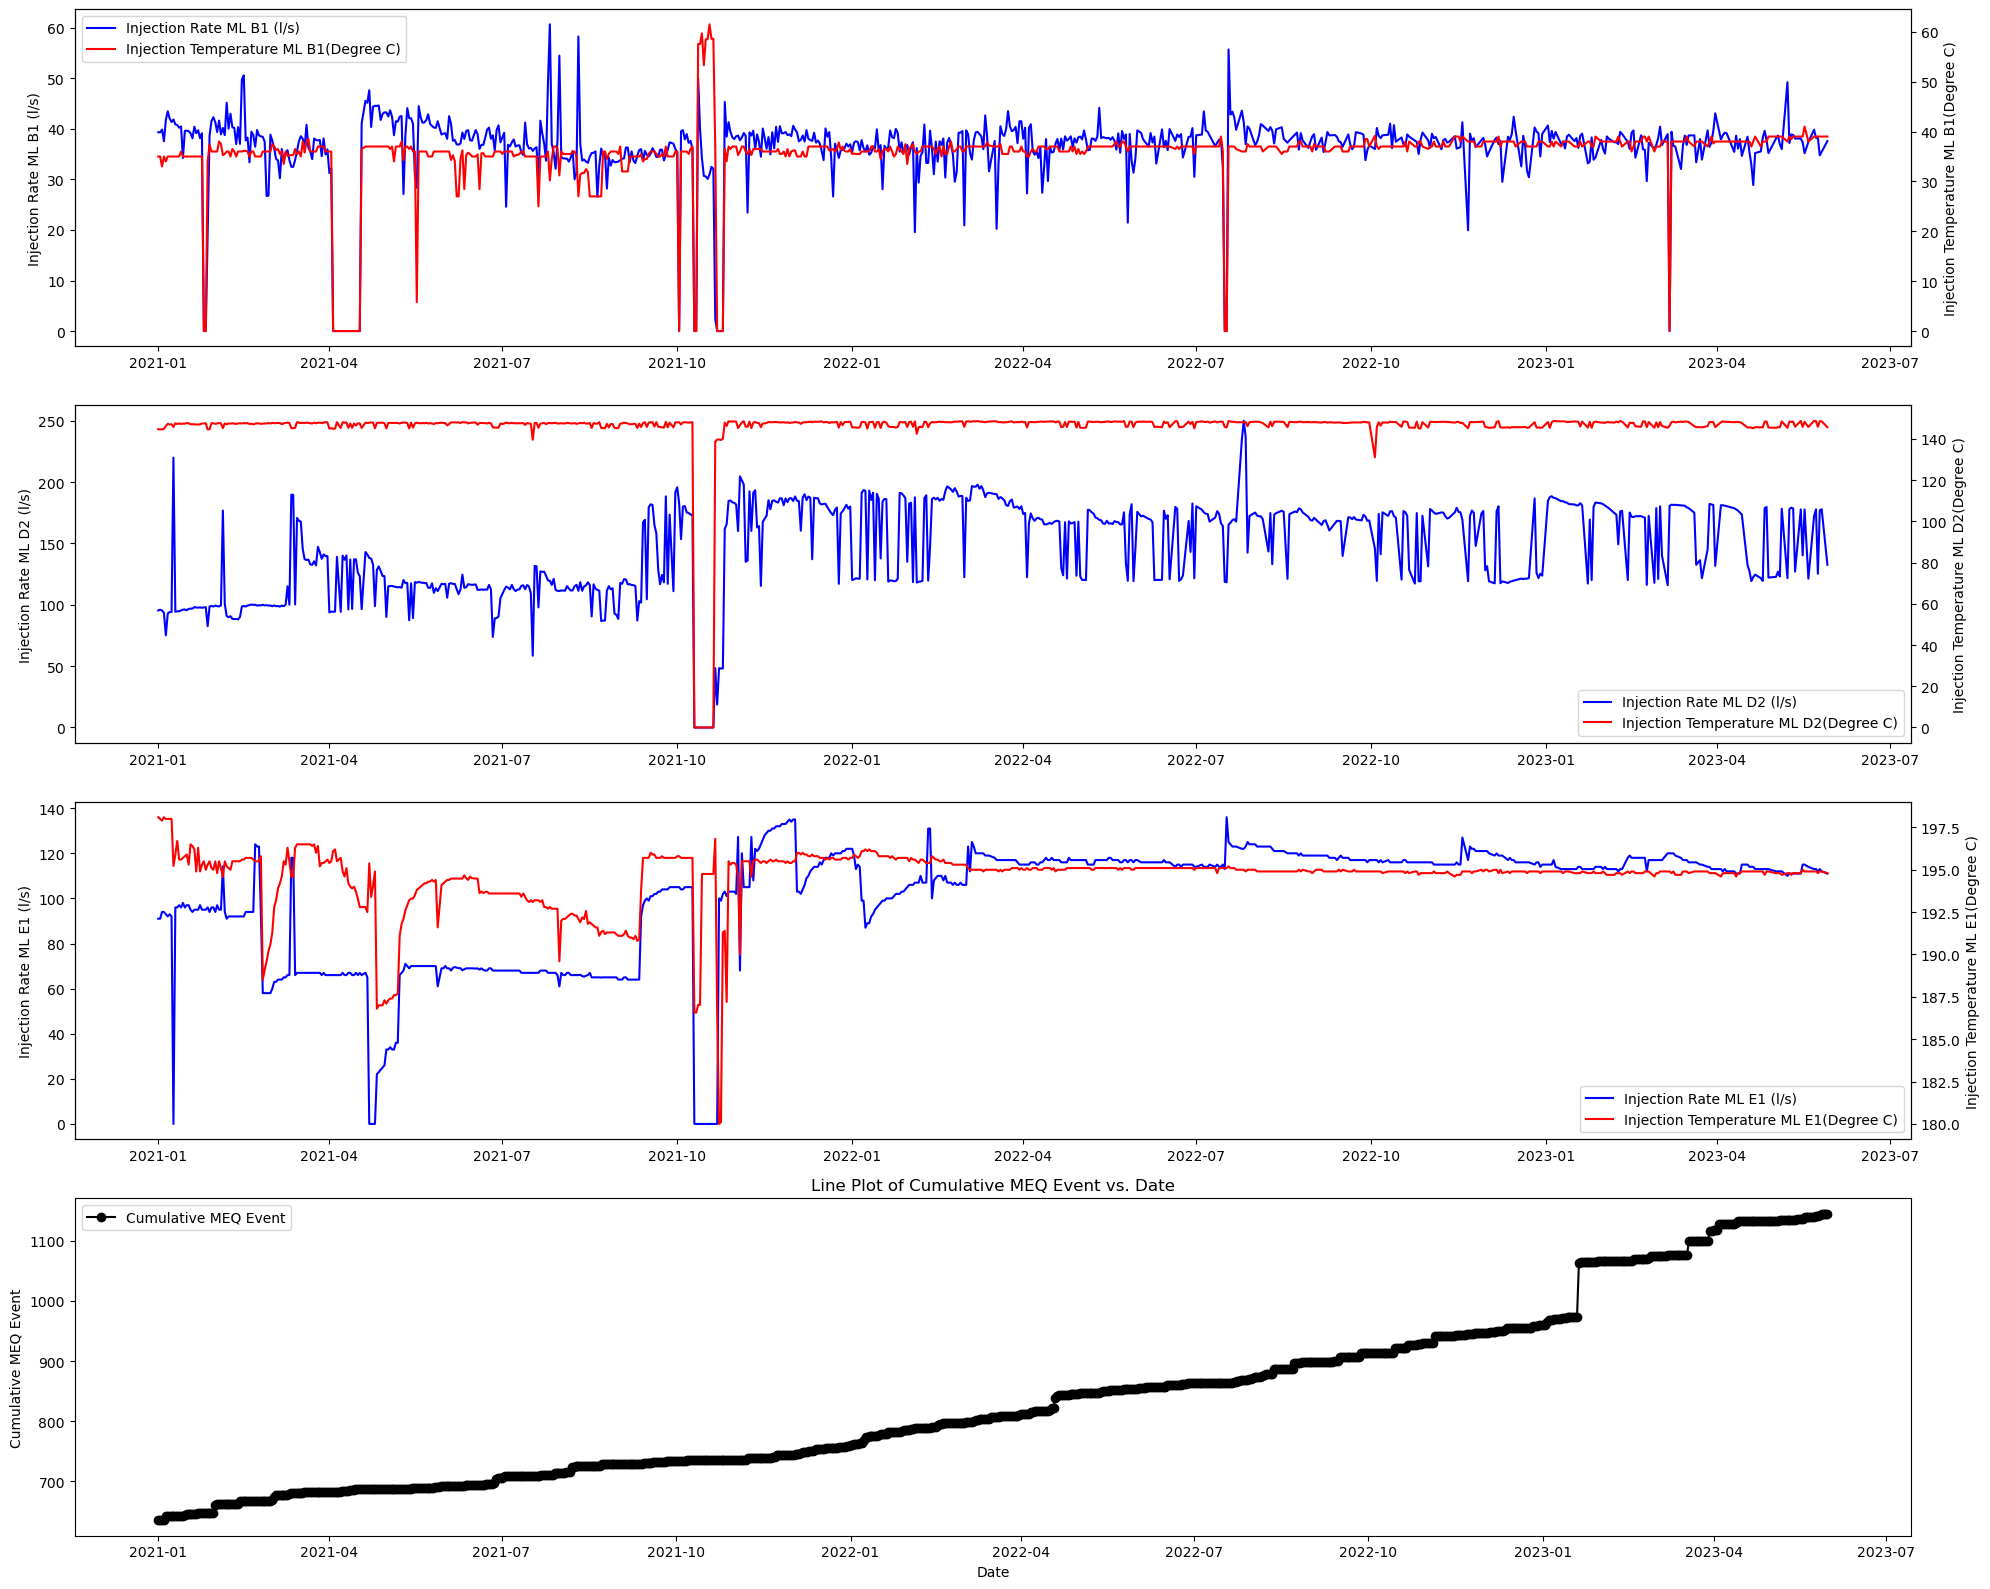

In [85]:
# Create a figure and axis for the subplot
fig, axs = plt.subplots(4, 1, figsize=(20, 16))

# Plot the first set of data (Injection Rate ML B1) and Injection Temperature ML B1 on the first subplot
axs[0].plot(result_merge['date'], result_merge['Injection Rate ML B1 (l/s)'], color='blue', label='Injection Rate ML B1 (l/s)')
axs[0].set_ylabel('Injection Rate ML B1 (l/s)', color='black')
axs[0].tick_params(axis='y', labelcolor='black')

axs2 = axs[0].twinx()
axs2.plot(result_merge['date'], result_merge['Injection Temperature ML B1(Degree C)'], color='red', label='Injection Temperature ML B1(Degree C)')
axs2.set_ylabel('Injection Temperature ML B1(Degree C)', color='black')
axs2.tick_params(axis='y', labelcolor='black')

# Add legend for the first subplot
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = axs2.get_legend_handles_labels()
axs[0].legend(lines + lines2, labels + labels2, loc='upper left')

# Plot the second set of data (Injection Rate ML D2) and Injection Temperature ML D2 on the second subplot
axs[1].plot(result_merge['date'], result_merge['Injection Rate ML D2 (l/s)'], color='blue', label='Injection Rate ML D2 (l/s)')
axs[1].set_ylabel('Injection Rate ML D2 (l/s)', color='black')
axs[1].tick_params(axis='y', labelcolor='black')

axs3 = axs[1].twinx()
axs3.plot(result_merge['date'], result_merge['Injection Temperature ML D2(Degree C)'], color='red', label='Injection Temperature ML D2(Degree C)')
axs3.set_ylabel('Injection Temperature ML D2(Degree C)', color='black')
axs3.tick_params(axis='y', labelcolor='black')

# Add legend for the second subplot
lines, labels = axs[1].get_legend_handles_labels()
lines2, labels2 = axs3.get_legend_handles_labels()
axs[1].legend(lines + lines2, labels + labels2, loc='lower right')

# Plot the third set of data (Injection Rate ML E1) and Injection Temperature ML E1 on the third subplot
axs[2].plot(result_merge['date'], result_merge['Injection Rate ML E1 (l/s)'], color='blue', label='Injection Rate ML E1 (l/s)')
axs[2].set_ylabel('Injection Rate ML E1 (l/s)', color='black')
axs[2].tick_params(axis='y', labelcolor='black')

axs4 = axs[2].twinx()
axs4.plot(result_merge['date'], result_merge['Injection Temperature ML E1(Degree C)'], color='red', label='Injection Temperature ML E1(Degree C)')
axs4.set_ylabel('Injection Temperature ML E1(Degree C)', color='black')
axs4.tick_params(axis='y', labelcolor='black')

# Add legend for the third subplot
lines, labels = axs[2].get_legend_handles_labels()
lines2, labels2 = axs4.get_legend_handles_labels()
axs[2].legend(lines + lines2, labels + labels2, loc='lower right')

# Filter the DataFrame to include data from January 1, 2021, to the end of May 2023
filtered_df = df2[(df2['date'] >= '2021-01-01') & (df2['date'] <= '2023-05-31')]

# Plot the fourth set of data (Cumulative MEQ Event) on the fourth subplot
axs[3].plot(filtered_df['date'], filtered_df['cum_sum_meq_event'], marker='o', linestyle='-', color='black')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Cumulative MEQ Event')
axs[3].set_title('Line Plot of Cumulative MEQ Event vs. Date')

# Add legend for the fourth subplot
axs[3].legend(['Cumulative MEQ Event'], loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Injectivity depends on the temperature of injected water in all wells, which could be explained by thermomechanical effects promoting fracture opening in fractured reservoirs (Gunnarsson, 2011). Hydraulic and thermoelastic effects exert different influences on the characteristics (intensity, location and timing) of induced seismicity due to differences in the physical processes of fluid flow and heat transfer and the associated intrinsic hydrological and thermodynamic parameters. While the occurrence of seismic events is subject to the combined effects of these mechanisms, the extent to which seismic intensity is influenced by pore pressure changes and thermoelastic stresses varies between sites, depending on the local stress states and field operating conditions (injection pressure and temperature of the injected fluid) (Cao et al, 2022).

In the ML B1 condensate well and the ML D2 and ML E1 brine wells, it can be seen that the temperature of the re-injected fluids and the amount of re-injected fluids have a similar trend and tend to be positively correlated. The ML E1 brine well has been around 195 degrees Celsius since the end of 2021 and ML D2 always provides a re-injected fluid temperature around 140 degrees Celsius and the ML B1 condensate well only provides a re-injected fluid temperature around 40 degrees Celsius. In November 2021 there was a shut-in of the temperature of the reinjected fluids for the brine wells ML D2 and ML E1, but not for the condensate well ML B1. From the beginning of 2022 until May 2023, the brine wells ML D2 and ML E1 did not experience any shut-in, while the condensate well ML B1 experienced 2 shut-ins.

From the visualisation of the temperature of the reinjected fluids and the amount of fluid reinjected, it is not very clear that there is a relationship between the temperature of the injection fluid and the rate of injection with an increase in microseismic events.

In [86]:
result_merge['Cum Sum Injection Rate ML B1 (l/s)'] = result_merge['Injection Rate ML B1 (l/s)'].cumsum()
result_merge['Cum Sum Injection Rate ML C1 (l/s)'] = result_merge['Injection Rate ML C1 (l/s)'].cumsum()
result_merge['Cum Sum Injection Rate ML D1 (l/s)'] = result_merge['Injection Rate ML D1 (l/s)'].cumsum()
result_merge['Cum Sum Injection Rate ML D2 (l/s)'] = result_merge['Injection Rate ML D2 (l/s)'].cumsum()
result_merge['Cum Sum Injection Rate ML E1 (l/s)'] = result_merge['Injection Rate ML E1 (l/s)'].cumsum()
result_merge['Cum Sum Injection Rate ML E2 (l/s)'] = result_merge['Injection Rate ML E2 (l/s)'].cumsum()

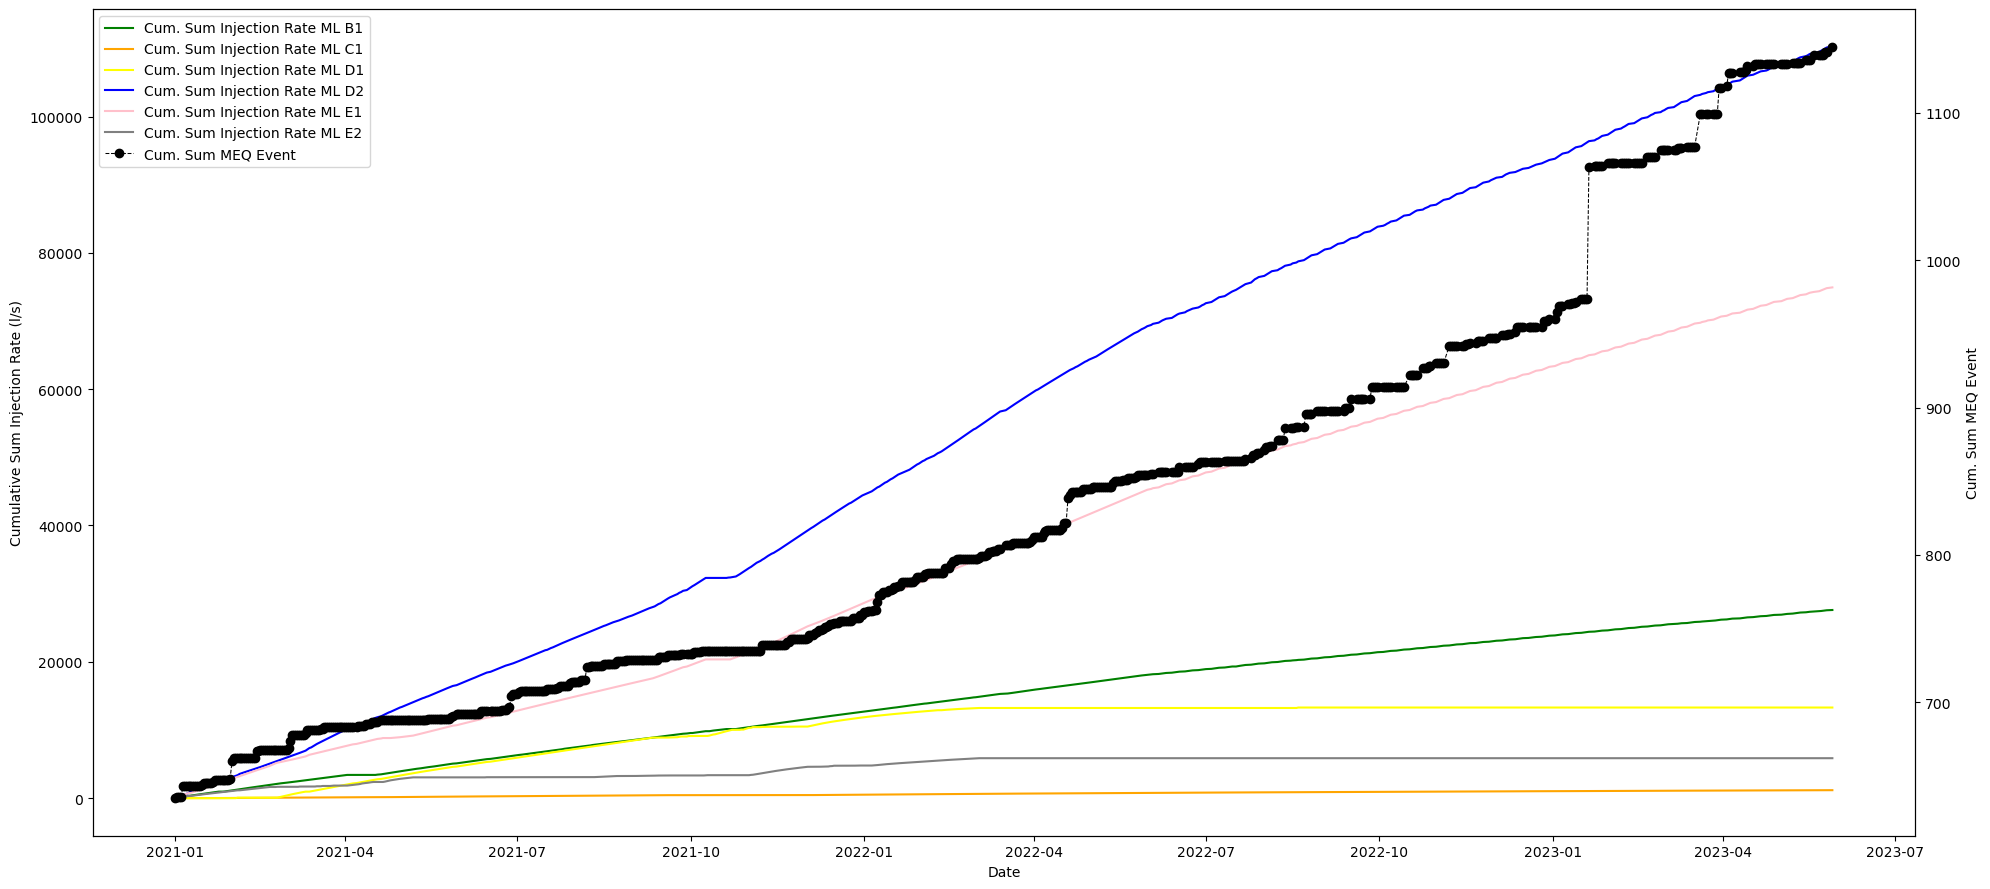

In [87]:
# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(20, 9))

# Plot the first set of data (Injection Rate) on the first y-axis (ax1)
ax1.plot(result_merge['date'], result_merge['Cum Sum Injection Rate ML B1 (l/s)'], color='green', label='Cum. Sum Injection Rate ML B1')
ax1.plot(result_merge['date'], result_merge['Cum Sum Injection Rate ML C1 (l/s)'], color='orange', label='Cum. Sum Injection Rate ML C1')
ax1.plot(result_merge['date'], result_merge['Cum Sum Injection Rate ML D1 (l/s)'], color='yellow', label='Cum. Sum Injection Rate ML D1')
ax1.plot(result_merge['date'], result_merge['Cum Sum Injection Rate ML D2 (l/s)'], color='blue', label='Cum. Sum Injection Rate ML D2')
ax1.plot(result_merge['date'], result_merge['Cum Sum Injection Rate ML E1 (l/s)'], color='pink',label='Cum. Sum Injection Rate ML E1')
ax1.plot(result_merge['date'], result_merge['Cum Sum Injection Rate ML E2 (l/s)'], color='grey',label='Cum. Sum Injection Rate ML E2')

# Set the label and color for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Sum Injection Rate (l/s)', color='black')

# Create a second y-axis for the second plot
ax2 = ax1.twinx()

# Plot the second set of data (Total MEQ Event) on the second y-axis (ax2)
ax2.plot(result_merge['date'], result_merge['cum_sum_meq_event'], linewidth=0.75, marker='o', linestyle='--', color='black', label='Cum. Sum MEQ Event')

# Set the label and color for the second y-axis
ax2.set_ylabel('Cum. Sum MEQ Event')

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Set the title and adjust layout
#plt.title('Injection Rate vs. Total MEQ Event Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


Seismicity during this period is characterised by increasing sensitivity to injection, in that more and more microseismic events occur per unit total injection rate, and that this is driven by fluid pressure changes that increase in size and extent as cumulative injection volume increases.

In [88]:
result_merge

,date,Injection Rate ML B1 (l/s),Injection Rate ML C1 (l/s),Injection Rate ML D1 (l/s),Injection Rate ML D2 (l/s),Injection Rate ML E1 (l/s),Injection Rate ML E2 (l/s),WHP ML B1 (barg),WHP ML C1 (barg),WHP ML D1 (barg),...,cum_sum_meq_event,year,month,day,Cum Sum Injection Rate ML B1 (l/s),Cum Sum Injection Rate ML C1 (l/s),Cum Sum Injection Rate ML D1 (l/s),Cum Sum Injection Rate ML D2 (l/s),Cum Sum Injection Rate ML E1 (l/s),Cum Sum Injection Rate ML E2 (l/s)
0,2021-01-01,39.33,0.0,0.0,95.4,91.0,40.0,2.29,0.0,-0.71,...,635,2021,1,1,39.3300,0.000,0.000,95.400,91.00,40.00
1,2021-01-02,39.33,0.0,0.0,96.0,91.0,40.0,2.35,0.0,-0.69,...,636,2021,1,2,78.6600,0.000,0.000,191.400,182.00,80.00
2,2021-01-03,39.87,0.0,0.0,95.4,94.0,40.0,3.03,0.0,-0.68,...,636,2021,1,3,118.5300,0.000,0.000,286.800,276.00,120.00
3,2021-01-04,37.57,0.0,0.0,93.4,94.0,40.0,2.59,0.0,-0.66,...,636,2021,1,4,156.1000,0.000,0.000,380.200,370.00,160.00
4,2021-01-05,41.78,0.0,0.0,75.1,93.0,40.0,4.10,0.0,-0.65,...,643,2021,1,5,197.8800,0.000,0.000,455.300,463.00,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2023-05-23,38.24,1.6,0.0,177.8,113.0,0.0,3.83,9.0,-0.76,...,1139,2023,5,23,27456.1325,1162.775,13294.675,109649.475,74483.97,5860.89
760,2023-05-24,38.26,1.1,0.0,125.3,112.0,0.0,3.81,9.0,-0.76,...,1139,2023,5,24,27494.3925,1163.875,13294.675,109774.775,74595.97,5860.89
761,2023-05-25,34.77,1.2,0.0,177.0,113.0,0.0,2.83,9.0,-0.77,...,1141,2023,5,25,27529.1625,1165.075,13294.675,109951.775,74708.97,5860.89
762,2023-05-26,35.48,1.4,0.0,177.9,112.0,0.0,2.82,9.0,-0.76,...,1141,2023,5,26,27564.6425,1166.475,13294.675,110129.675,74820.97,5860.89


# Business Implementation

**1.  Establishing Discrete Fracture Network (DFN) for numerical simulation**

The effective and confirmatory numerical simulation technique associated with the discrete fracture network constructed based on microseismicity data will help to estimate the power output for specific years based on the P10/P50/P90 scenario and describe the geothermal resource potential in MWe. 

**2. Identifying fluid path**

Induced seismicity recorded due to fault reactivation that produces a swarm of fractures, will show the orientation of the fractures. For example, in our cases, a cluster of microseismic events described in ENE-WSW, this cluster could be aligned with structural trends, indicating that the events could be correlated with these structures. If so, this structure is favourable for geothermal fluid flow.  


**3. Assisting well targeting**

The information from microseismicity would help to determine the permeable zone of the geothermal area, as well as the reservoir connectivity, which could help to locate injection and production wells.

# Conclusion

**1. MEQ Catalogue Quality**
   - In the MEQ catalogue records from December 2019-October 2023, missing values are still dominant in the local and moment magnitude features, but the missing values are filled using the KNN imputation method.  
   - The data contained in the catalogue are categorized as microseismic event as their magnitude are less than 3.
   - MEQ events majorly have an RMS error range in the range of 0 - 0.05, this indicates that this MEQ catalog is reliable.
   
**2. MEQ Data Analysis**
   - A total of 1534 MEQ events were detected over a period of ±4 years.  
   - This dataset is comprised of 58.7% of events that have been processed up to the WCC stage, and shows 2 clusters, one of which clearly shows an ENE-WSW orientation.
   - The majority of MEQ events occur at shallow depths (-2000 - 0 m) from late 2019 until the fourth quarter of 2023.
   - Remarkable rises in microseismic activity occur in the first five months of 2020 and during 2023. However, there is less microseismicity in the intervening period.
   
**3. Operational Reservoir Parameter Data Analysis**
   - ML E1 was identified as the well with the highest average of injection temperature and WHP.
   - Compared to the other wells, ML D2 was the highest in average injection rate and the highest in average FCV opening percentage.
   
**4. Integrated MEQ and Reservoir Data Analysis**
   - The temperature of reinjected fluids and the amount of reinjected fluids follow a similar trend and tend to correlate positively.
   - By plotting the injection rate and injection temperature of all wells against the total daily MEQ events from January 2021 to May 2023, it is not very clear that there is a relationship between these two reservoir operating parameters and increased microseismic events.
   - According to the visualization of WHP against the total daily MEQ events, the intensity of the microseismicity started to increase after the first quarter of 2022 and increased dramatically in the first quarter of 2023. This is inline with ML D1 and ML E2 wellhead pressures being fully minimalized, while ML E1 was increased and ML D2 reduced and maintained in the 7-17 barg range. 

# Recommendation

   1. Combined microseismic analysis with reservoir operational data will be more comprehensive when both datasets have the same data availability date. In this case, MEQ and reservoir data are only synchronised from 1 January 2021 to 29 May 2023. If possible, reservoir operational data should be available from December 2019 to December 2020 and from 30 May 2023 to the present.

   2. In order to identify which features influence the occurrence of daily microseismic events, the application of machine learning methods with tree-based models for feature-of-importance analysis can be helpful.
   
   3. Data-driven modelling can be performed, as in the work of Yu et al. (2023), who applied two classes of models: (a) lagged linear regression of seismicity rate as a function of well injection rates; and (b) systematic extraction of injection time series features, which were then evaluated for associations with seismicity. Using these models, we were able to determine which wells had the highest correlation with microseismicity.

# References

- AlQassab, M., Yu, W., Sepehrnoori, K., Kerr, E., Scofield, R., Johnson, A. (2020). Estimating the Size and Orientation of Hydraulic Fractures using Microseismic Events
- Bachi, Hana, Wu, Jianfa, Liu, Chuxi, Yang, Xuefeng, Chang, Cheng, Yu, Wei, and Kamy Sepehrnoori. (2023). "An Efficient Hydraulic Fracture Geometry Calibration Workflow Using Microseismic Data.
- Catalli, F., Rinaldi, A. P., Gischig, V., Nespoli, M., & Wiemer, S. (2016). The importance of earthquake interactions for injection-induced seismicity: Retrospective modeling of the Basel Enhanced Geothermal System
- Cao W., Durucan S., Shi J., Cai W., Korre A., Ratouis T. (2022). Induced seismicity associated with geothermal fluids re-injection: Poroelastic stressing, thermoelastic stressing, or transient cooling-induced permeability enhancement?
- Ciardo, F., & Rinaldi, A. P. (2022). Impact of injection rate ramp-up on nucleation and arrest of dynamic fault slip. 
- Dempsey, D. E., & Riffault, J. (2019). Response of induced seismicity to injection rate reduction: Models of delay, decay, quiescence, recovery, and Oklahoma
- Gunnarsson, G. (2011). Mastering reinjection in the Hellisheidi field, Sw-Iceland: A story of successes and failures.
- Izadi, G., Elsworth, D. (2015). The influence of thermal-hydraulic-mechanical-and chemical effects on the evolution of permeability, seismicity and heat production in geothermal reservoirs. Geothermics 53, 385–395. 
- He, M., Li, Q., & Li, X. (2020). Injection-induced seismic risk management using machine learning methodology—A perspective study. 
- Hofmann, H., Zimmermann, G., Zang, A., & Min, K. B. (2018). Cyclic soft stimulation (CSS): A new fluid injection protocol and traffic light system to mitigate seismic risks of hydraulic stimulation treatments. 
- Hubbert King, M., & Rubey, W. W. (1959). Role of fluid pressure in mechanics of overthrust faulting: I. Mechanics of fluid-filled porous solids and its application to overthrust faulting.
- Li, Y., Zhang, Q., Gong, Y., Liu, C., Leines-Artieda, J. A, and Yu, W. (2022). Calibration of Complex Discrete Fracture Network Using Microseismic Events and Fracture Propagation Modelling with Seamless Reservoir Production Simulation.
- Shibo Sun, Wendong Wang, Yuliang Su, Yuxuan Deng, Haoyu Li. (2024). A Microseismic Events Cluster Analysis-based Method for Modelling Complex Fractures in Geothermal Reservoir
- Yu, P., Dempsey, D., Rinaldi, A. P., Calibugan, A., Ritz, V. A., Archer, R. (2023). Association Between Injection and Microseismicity in Geothermal Fields With Multiple Wells: Data-Driven Modeling of Rotokawa, New Zealand, and Húsmúli, Iceland